This notebook implements various models on the VHI dataset of Peninsular India

In [ ]:
import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [ ]:
import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
# from IPython.display import Image, display
# from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data Loading

In [ ]:
#data preprocessing

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]



In [ ]:
#@title
dataset = load_real_samples(r"C:\Users\Jyoti_Shukla\Documents\Jyoti\Peninsular\paired_padded_peninsular_arrays_train_AVHRR_data.npz")
dataset_test = load_real_samples(r"C:\Users\Jyoti_Shukla\Documents\Jyoti\Peninsular\paired_padded_peninsular_arrays_test_AVHRR_data.npz")
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (1899, 448, 576, 1), (1899, 448, 576, 1)
Validation Dataset Shapes: (60, 448, 576, 1), (60, 448, 576, 1)


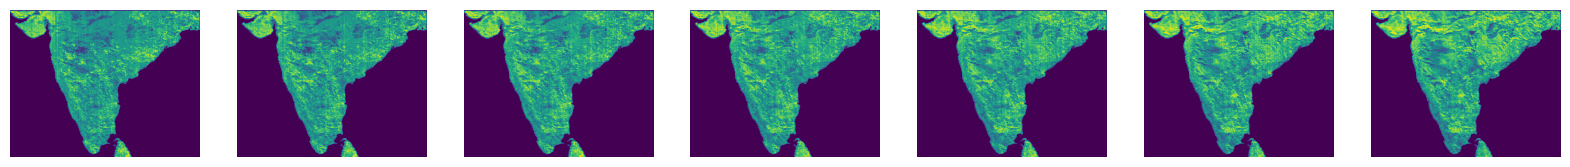

In [ ]:
from matplotlib import pyplot
idx = np.random.randint(0, len(dataset[0]),7)
plt.figure(figsize=(20,20))
for i in range(len(idx)):
    #define subplot
    pyplot.subplot(1,7,1+i)
    #turn off acis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(dataset[0][i].reshape(448,576))
    #show title
    #pyplot.title(titles[i])
pyplot.show()

## Sampling temporally to feed to LSTM

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [ ]:
dataset = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_train_AVHRR_data.npz")
dataset_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_AVHRR_data.npz")
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (1899, 192, 128, 1), (1899, 192, 128, 1)
Validation Dataset Shapes: (60, 192, 128, 1), (60, 192, 128, 1)


In [ ]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (1895, 4, 448, 576, 1), (1895, 448, 576, 1)
Validation Dataset Shapes: (56, 4, 448, 576, 1), (56, 448, 576, 1)


## ConvLSTM with Conv3D

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [ ]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (1895, 4, 448, 576, 1), (1895, 4, 448, 576, 1)
Validation Dataset Shapes: (56, 4, 448, 576, 1), (56, 4, 448, 576, 1)


## Convlstm and conv3d

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp.shape

TensorShape([None, None, 448, 576, 1])

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
#x = layers.Dropout(0.3)(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.3)(x)
#x = layers.UpSampling3D((2, 2,2))(x)

x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.UpSampling3D((2, 2,2))(x)
# x = layers.Dropout(0.3)(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=[tf.keras.metrics.mse]
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 256, 256,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_16 (ConvLSTM2D)  (None, None, 256, 256, 1  9856     
                             6)                                  
                                                                 
 batch_normalization_13 (Bat  (None, None, 256, 256, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv_lstm2d_17 (ConvLSTM2D)  (None, None, 256, 256, 3  55424    
                             2)                                  
                                                                 
 batch_normalization_14 (Bat  (None, None, 256, 256, 3  128

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 2

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
43/43 [==============================] - 215s 5s/step - loss: 0.0646 - cosine_similarity: 0.8949 - val_loss: 0.0557 - val_cosine_similarity: 0.9113 - lr: 0.1000
Epoch 2/30
43/43 [==============================] - 200s 5s/step - loss: 0.0598 - cosine_similarity: 0.9002 - val_loss: 0.0558 - val_cosine_similarity: 0.9112 - lr: 0.1000
Epoch 3/30
43/43 [==============================] - 200s 5s/step - loss: 0.0534 - cosine_similarity: 0.9122 - val_loss: 0.0561 - val_cosine_similarity: 0.9112 - lr: 0.1000
Epoch 4/30
43/43 [==============================] - 200s 5s/step - loss: 0.0442 - cosine_similarity: 0.9279 - val_loss: 0.0565 - val_cosine_similarity: 0.9111 - lr: 0.1000
Epoch 5/30
43/43 [==============================] - 200s 5s/step - loss: 0.0358 - cosine_similarity: 0.9402 - val_loss: 0.0564 - val_cosine_similarity: 0.9112 - lr: 0.1000
Epoch 6/30
43/43 [==============================] - 200s 5s/step - loss: 0.0315 - cosine_similarity: 0.9481 - val_loss: 0.0551 - val_cosine_

In [ ]:
model.save("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_morelayers_30epochs.h5")

In [ ]:
model.save("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_70epochs.h5")

In [ ]:
from keras.models import load_model
model_1 = load_model("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_70epochs.h5")
model_2= load_model("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_morelayers_30epochs.h5")

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 256, 256,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 256, 256, 1  9856      
                             6)                                  
                                                                 
 batch_normalization_4 (Batc  (None, None, 256, 256, 1  64       
 hNormalization)             6)                                  
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, None, 256, 256, 3  55424     
                             2)                                  
                                                                 
 batch_normalization_5 (Batc  (None, None, 256, 256, 3  128

In [ ]:
framed = x_test[3][:1,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[3][0]
pred = pred.reshape(256,256,1)
plt.imshow(pred.reshape(256,256))
plt.figure()
plt.imshow(y_real.reshape(256,256))

ValueError: ignored

In [ ]:
np.max(pred),np.max(y_real)

(0.5000752, 1.0000000000000004)

In [ ]:
#extracting predicted frame from every series of 4 images
test_predicted = model_1.predict(x_test)
#predicted.shape[0]
p =[]
for i in range(test_predicted.shape[0]):
  arr = test_predicted[i][0]
  p.append(arr)
test_set = np.asarray(p)
test_set.shape

(17, 256, 256, 1)

In [ ]:
train_predicted = model.predict(x_train)
p=[]
for i in range(train_predicted.shape[0]):
  arr = train_predicted[i][0]
  p.append(arr)
train_set = np.asarray(p)
train_set.shape

(86, 256, 256, 1)

In [ ]:
#save the temporal values in txt file
# saving the temporal features values
train_file = open("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/train_lstm3D.txt","w")
for i in range(train_set.shape[0]):
  array = train_set[i].reshape(256,256)
  np.savetxt(train_file,array)
train_file.close()

test_file = open("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/test_lstm3D.txt","w")
for i in range(test_set.shape[0]):
  array = test_set[i].reshape(256,256)
  np.savetxt(test_file,array)
test_file.close()


In [ ]:
example = x_test[np.random.choice(range(len(x_test)), size=1)[0]]
frames = example[:2, ...]
original_frames = example[2:, ...]

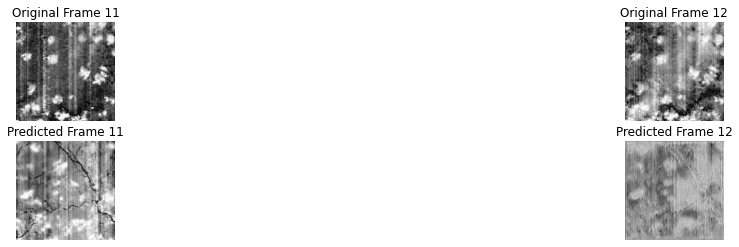

In [ ]:
# Predict a new set of 10 frames.
for _ in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 2, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[1:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
original_frames[1]

In [ ]:
frames[0]

In [ ]:
frames[1]

In [ ]:
frames[2]

In [ ]:
frames[3]

## ABOVE MODEL WITH HUBER LOSS

In [ ]:
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =4)(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =8)(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =16)(x)
#x = layers.Dropout(0.3)(x)
#x = layers.UpSampling3D((2, 2,2))(x)

x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = tfa.layers.GroupNormalization(groups =32)(x)
#x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=256,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = tfa.layers.GroupNormalization(groups =64)(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = tfa.layers.GroupNormalization(groups =8)(x)
#x = layers.UpSampling3D((2, 2, 2))(x)
# x = layers.Dropout(0.3)(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =4)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
huber_loss = tf.keras.losses.Huber(delta=0.01)
# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss= huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=[tf.keras.metrics.mse]
)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 448, 576, 1 0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 448, 576, 16 9856      
_________________________________________________________________
group_normalization (GroupNo (None, None, 448, 576, 16 32        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 448, 576, 32 55424     
_________________________________________________________________
group_normalization_1 (Group (None, None, 448, 576, 32 64        
_________________________________________________________________
dropout (Dropout)            (None, None, 448, 576, 32 0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 448, 576, 64 221440

In [ ]:
train = x_train[:10]
train_y = y_train[:10]
test = x_test[:5]
test_y = y_test[:5]

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 1

# Fit the model to the training data.
history = model.fit(
    train,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test, test_y),
    callbacks=[early_stopping, reduce_lr],
)

# model.save("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR/convlstm_conv3d_AVHRR_model.h5")

# # Results of updated model
# np.save('F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR/convlstm_conv3d_AVHRR_model_history.npy',history.history)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model= load_model("F:\Jyoti Shukla -MS\codes\AVHRR codes\peninsular codes\Peninsular convlstm conv3d outputs\peninsular_convlstm_conv3d_AVHRR_model_4.1.h5")
history=np.load('F:\Jyoti Shukla -MS\codes\AVHRR codes\peninsular codes\Peninsular convlstm conv3d outputs\peninsular_convlstm_conv3d_AVHRR_model_4.1_history.npy',allow_pickle='TRUE').item()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 448, 576, 1 0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 448, 576, 16 4416      
_________________________________________________________________
group_normalization_1 (Group (None, None, 448, 576, 16 32        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 448, 576, 32 24704     
_________________________________________________________________
group_normalization_2 (Group (None, None, 448, 576, 32 64        
_________________________________________________________________
dropout (Dropout)            (None, None, 448, 576, 32 0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 448, 576, 64 98560 

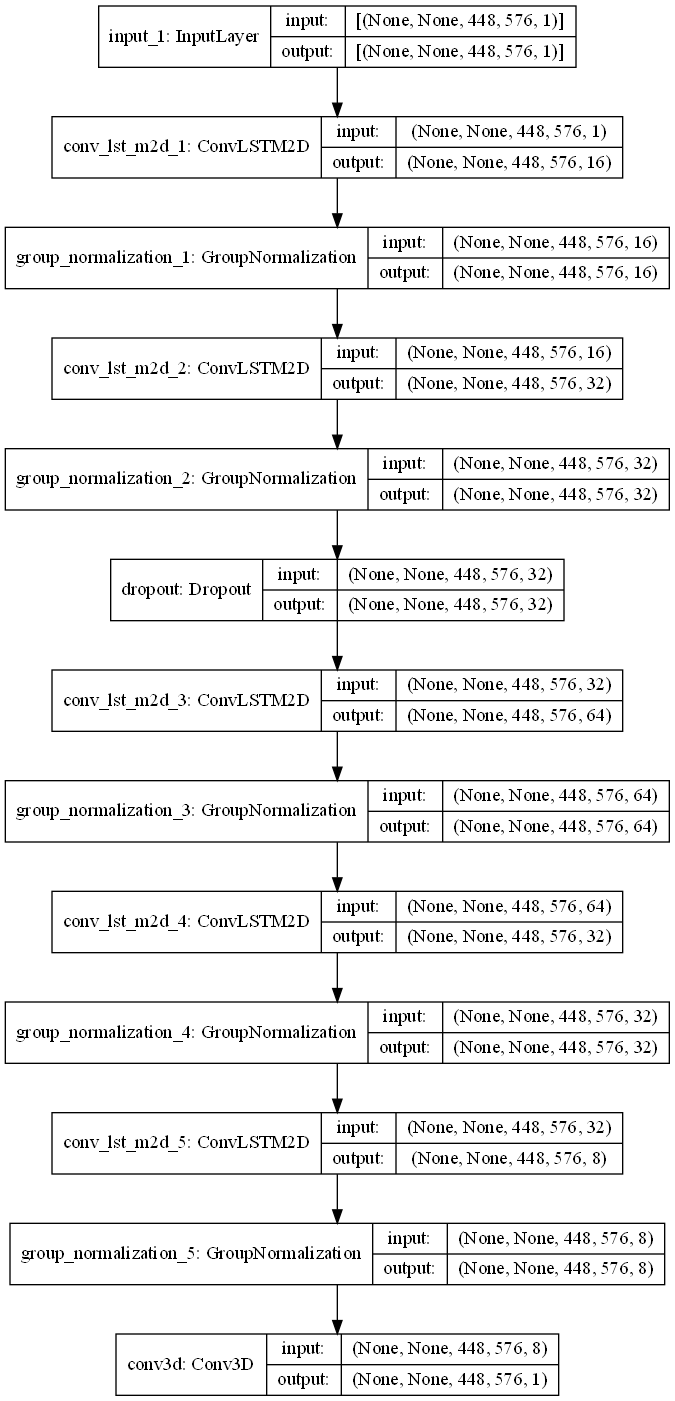

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

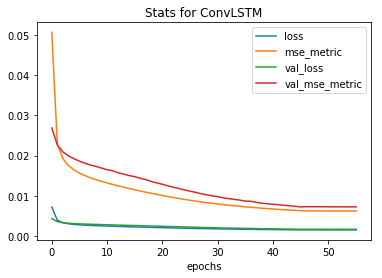

In [ ]:
# Results of updated model

plt.plot(history['loss'])
plt.plot(history['mean_squared_error'])
plt.plot(history['val_loss'])
plt.plot(history['val_mean_squared_error'])

plt.title('Stats for ConvLSTM')
plt.xlabel('epochs')
plt.legend(['loss','mse_metric','val_loss','val_mse_metric'])
plt.show()

In [ ]:
tf.function(experimental_relax_shapes=True)

<function tensorflow.python.eager.def_function.function.<locals>.decorated(inner_function)>

mse 0.015538273038628148
r2 score is: 0.8132530685366093 

discrete values, predicted and real respectively: 0.8006554 0.8027067638578869


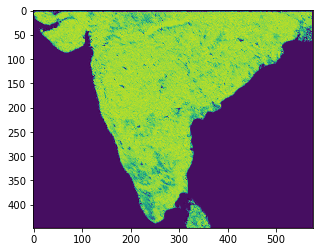

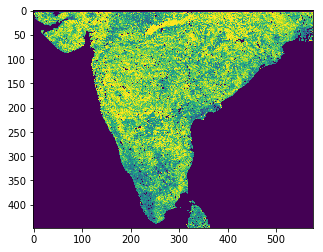

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
framed = x_test[2][:1,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[2][0]
pred = pred.reshape(448,576,1)
plt.imshow(pred.reshape(448,576))
plt.figure()
plt.imshow(y_real.reshape(448,576))
r2 = r2_score(y_real.reshape(448,576),pred.reshape(448,576))
mse = mse(y_real.reshape(448,576),pred.reshape(448,576))
print("mse",mse)
print("r2 score is:", r2,"\n")
pred = pred.reshape(448,576)
y_real = y_real.reshape(448,576)
print("discrete values, predicted and real respectively:",(pred.reshape(448,576))[50][30],(y_real.reshape(448,576))[50][30])

In [ ]:
pred = pred.reshape(448,576)
y_real = y_real.reshape(448,576)
print((pred.reshape(448,576))[20][30],(y_real.reshape(448,576))[20][30])

0.8263647 0.8153383642210996


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted =[]
true = []
R2 =[]
res = []
MSE =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i][0].reshape(448,576)
    test = framed.reshape(1,1,448,576,1)
    pred = model.predict(test)
    pred = pred.reshape(448,576)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    err = mse(y_real,pred)
    MSE.append(err)
    res.append(residual)
    predicted.append(pred)
    true.append(y_real)
    R2.append(r2)

np.save("R2_score_convLSTM+conv3D_2.1.npy", R2)
np.save("MAE_for_ConvLSTM+ Conv3D_2.1.npy",res)
np.save("MSE_for_ConvLSTM+Conv3D_2.1.npy",MSE)
np.save("Predicted_outputs_ConvLSTM+Conv3D_2.1.npy", predicted)


# r2 = r2_score(y_real, pred)
print(len(R2))
print('r2 score for test data on model is: \n', R2)

56
r2 score for test data on model is: 
 [0.8104886553821454, 0.8188381510902072, 0.8132530685366093, 0.8122923860491924, 0.7943585722799618, 0.7624502162928947, 0.7178307876099017, 0.676041825622459, 0.6397576377429045, 0.6041777413558205, 0.5533806433319239, 0.5056015623063199, 0.48704747525083963, 0.4874504566084333, 0.5120450493194255, 0.535648568861947, 0.5824168369650666, 0.626575536346471, 0.668381084877377, 0.7053619756224364, 0.719697994984239, 0.7296761591478892, 0.7394937733136039, 0.7374603220646887, 0.7244691016076111, 0.7322810741316332, 0.7321689214467322, 0.7332890449845616, 0.7280694686543557, 0.7358718598079732, 0.7438804147820206, 0.7466005964567013, 0.7618868700846101, 0.781430204029224, 0.7906165169038645, 0.7663665739126735, 0.7871472355779839, 0.7860260703787431, 0.7765249022569731, 0.7741903408915696, 0.7692389559810076, 0.7556537373557995, 0.7287302519844735, 0.7034429623216218, 0.6692897080464483, 0.7006859854159949, 0.6213823639270222, 0.6577335468772163, 0.6

In [ ]:
R2[32:35], res[32:35], MSE[32:35]

([0.8023446797201537, 0.7929940595350344, 0.7867991235696205],
 [0.07217923128574483, 0.07614482620744514, 0.07884817539556169],
 [0.015101043776643822, 0.016680814618614134, 0.01788806416453277])

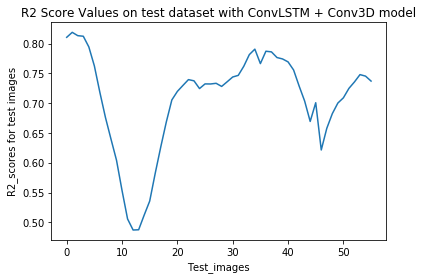

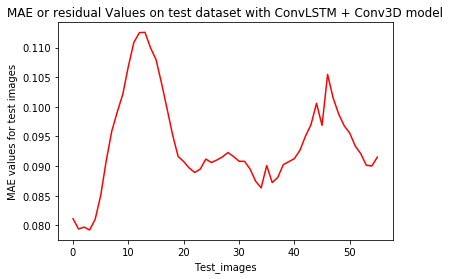

Text(0.5,1,'MSE Values on test dataset with ConvLSTM + Conv3D model')

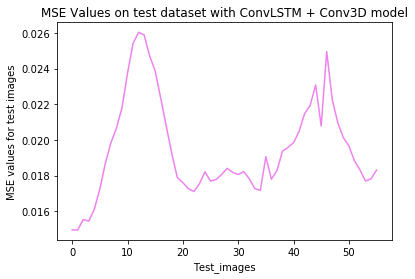

In [ ]:
R2 = np.load("R2_score_convLSTM+conv3D_2.1.npy")
res = np.load("MAE_for_ConvLSTM+ Conv3D_2.1.npy")
MSE = np.load("MSE_for_ConvLSTM+Conv3D_2.1.npy")
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ConvLSTM + Conv3D model")

In [ ]:
example = x_train[np.random.choice(range(len(x_test)), size=1)[0]]
frames = example[:3, ...]
original_frames = example[1:, ...]

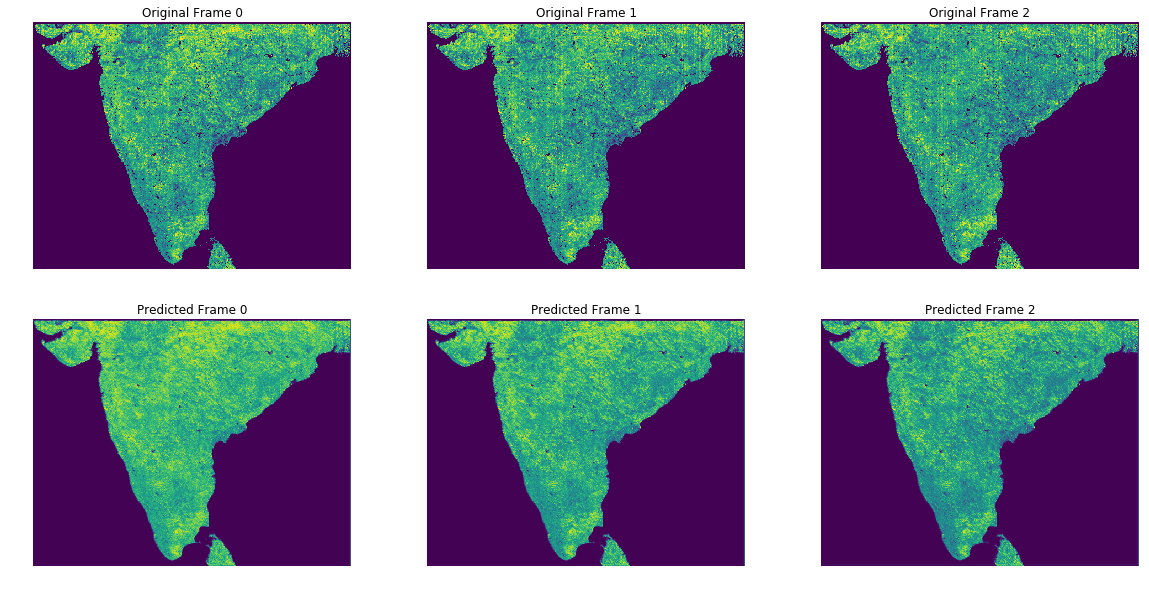

In [ ]:
# Predict a new set of 10 frames.
example = x_test[np.random.choice(range(len(x_test)), size=1)[0]]
frames = example[:3, ...]
original_frames = example[1:, ...]
for _ in range(3):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
#print(frames.shape)
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]))
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[3:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]))
    ax.set_title(f"Predicted Frame {idx}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
# unscaling values
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test)
  unscaled = scaler.inverse_transform(mat.reshape(448,576))
  return unscaled

In [ ]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

In [ ]:
#real unscaled data
VHI_train = np.loadtxt(r"F:\Jyoti Shukla -MS\Peninsular dataset\Padded_Peninsular_Train_AVHRR_data_1981_2022.txt").reshape(1900,448,576)
VHI_test = np.loadtxt(r"F:\Jyoti Shukla -MS\Peninsular dataset\Padded_Peninsular_Test_AVHRR_data_1981_2022.txt").reshape(61,448,576)
VHI_train = np.where(VHI_train<0,0,VHI_train)
VHI_test = np.where(VHI_test<0,0,VHI_test)
print(VHI_train.shape, VHI_test.shape)
print(np.max(VHI_train), np.min(VHI_train), np.max(VHI_test),np.min(VHI_test))

(1900, 448, 576) (61, 448, 576)
100.0 0.0 100.0 0.0


In [ ]:
x = VHI_train[:-1]
y = VHI_train[1:]
np.savez("F:\Jyoti Shukla -MS\Peninsular dataset/paired_unscaled_arrays_train_AVHRR_data.npz",x = x , y = y)

x = VHI_test[:-1]
y = VHI_test[1:]
np.savez("F:\Jyoti Shukla -MS\Peninsular dataset/paired_unscaled_arrays_test_AVHRR_data.npz",x = x , y = y)

In [ ]:
data_train = load_real_samples("F:\Jyoti Shukla -MS\Peninsular dataset/paired_unscaled_arrays_train_AVHRR_data.npz")
data_test = load_real_samples("F:\Jyoti Shukla -MS\Peninsular dataset/paired_unscaled_arrays_test_AVHRR_data.npz")
train_data, train_label = data_train[0], data_train[1]
test_data, test_label = data_test[0], data_test[1]
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)
vhi_train, vhi_train_label, n_steps = split_sequence(train_data, 4)
vhi_test, vhi_test_label, n_steps = split_sequence(test_data,4)
print("Training Dataset Shapes: " + str(vhi_train.shape) + ", " + str(vhi_train_label.shape))
print("Validation Dataset Shapes: " + str(vhi_test.shape) + ", " + str(vhi_test_label.shape))

(1899, 448, 576) (1899, 448, 576) (60, 448, 576) (60, 448, 576)
Training Dataset Shapes: (1895, 4, 448, 576), (1895, 4, 448, 576)
Validation Dataset Shapes: (56, 4, 448, 576), (56, 4, 448, 576)


In [ ]:
(original_frames[0]).shape,np.squeeze(original_frames[0]).shape

((448, 576, 1), (448, 576))

In [ ]:
ix = np.random.choice(range(len(x_test)), size=1)[0]
print(ix)
example = x_test[ix]
print(example.shape)
frames = example[:3, ...]
original_frames = example[1:, ...]
np.unique(x_test[ix][2]),np.unique(frames[2]),np.unique(original_frames[1])

40
(4, 190, 124, 1)


(array([0.        , 0.0042    , 0.0062    , ..., 0.99845103, 1.        ,
        1.        ]),
 array([0.        , 0.0042    , 0.0062    , ..., 0.99845103, 1.        ,
        1.        ]),
 array([0.        , 0.0042    , 0.0062    , ..., 0.99845103, 1.        ,
        1.        ]))

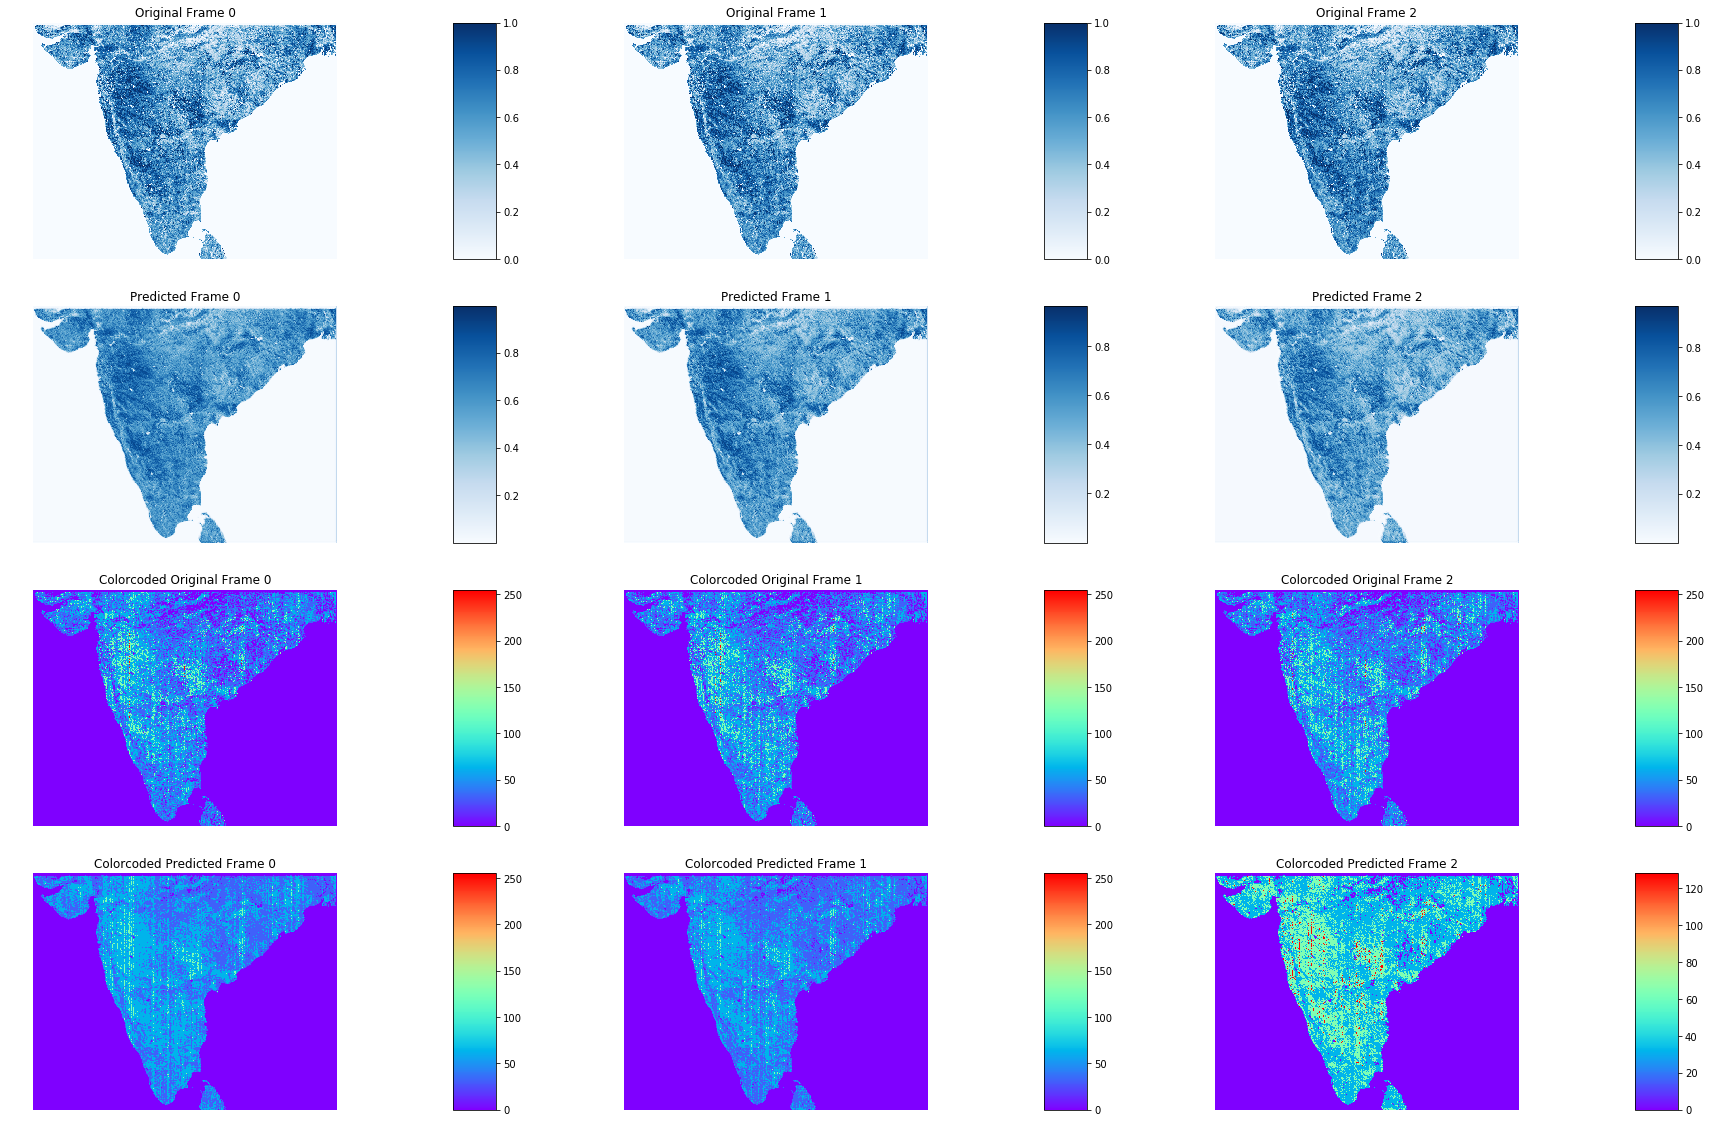

In [ ]:
# Predict a new set of 10 frames.
ix = np.random.choice(range(len(x_test)), size=1)[0]
example = x_test[ix]
frames = example[:3, ...]
original_frames = example[1:, ...]
for _ in range(3):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
#print(frames.shape)
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(4, 3, figsize=(30, 20))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    pos = ax.imshow(np.squeeze(original_frames[idx]), cmap="Blues")
    ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

# Plot the new frames.
new_frames = frames[3:, ...]
for idx, ax in enumerate(axes[1]):
    pos =ax.imshow(np.squeeze(new_frames[idx]), cmap="Blues")
    ax.set_title(f"Predicted Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

for idx, ax in enumerate(axes[2]):
    orig = unscale(np.squeeze(original_frames[idx]),vhi_test_label[ix][idx])
    colorcoded = colorcoding(orig)
    pos= ax.imshow(colorcoded, cmap='rainbow')
    ax.set_title(f"Colorcoded Original Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

new_frames = frames[3:, ...]
for idx, ax in enumerate(axes[3]):
    pred = unscale(np.squeeze(new_frames[idx]), vhi_test_label[ix][idx-3])
    colorcoded = colorcoding(pred)
    pos = ax.imshow(colorcoded, cmap='rainbow')
    ax.set_title(f"Colorcoded Predicted Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
ix

18

In [ ]:
train_image = train_dataset[:50]
train_label = train_labels[:50]
train_image_flattened = train_image.reshape(50,258048)
train_label_flattened = train_label.reshape(50,258048)

In [ ]:
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_image_flattened,train_label_flattened)

## ConvLSTM with conv2D

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=False,
    activation="sigmoid",
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    activation="relu",
)(x)
# x = layers.BatchNormalization()(x)
# #x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(
#     filters=32,
#     kernel_size=(3, 3),
#     padding="same",
#     activation="relu",
# )(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(
    filters=1,
    kernel_size=(3, 3),
    padding="same",
    activation="relu",
)(x)
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss='mae', optimizer='sgd',metrics=[tf.keras.metrics.mse]
)
model.summary()

NameError: name 'layers' is not defined

In [ ]:
inp.shape

TensorShape([None, None, 448, 576, 1])

In [ ]:
y_train.shape

(1895, 448, 576, 1)

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 1

# Fit the model to the training data.
history= model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
np.save("E:\Jyoti Shukla - MS\codes\AVHRR codes\peninsular outputs/convlstm+conv2d_history.npy", history.history)
model.save("E:\Jyoti Shukla - MS\codes\AVHRR codes\peninsular outputs/convlstm+conv2d_model.h5")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
np.save("F:\Jyoti Shukla -MS\codes\AVHRR codes/convlstm+conv2d_history.npy", history.history)
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

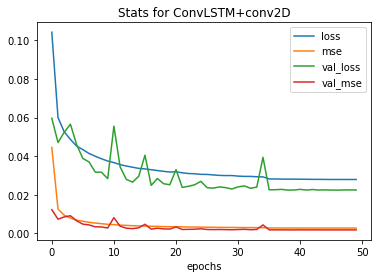

In [ ]:
# Results of updated model6

plt.plot(history.history['loss'])
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mean_squared_error'])

plt.title('Stats for ConvLSTM+conv2D')
plt.xlabel('epochs')
plt.legend(['loss','mse','val_loss','val_mse'])
plt.show()

In [ ]:
x_test[1].shape

(4, 192, 128, 1)

-1.2997286522730027


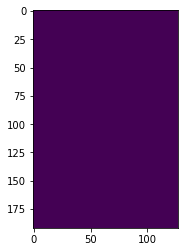

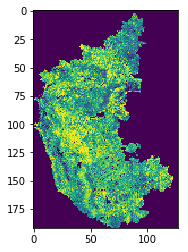

In [ ]:
from sklearn.metrics import r2_score
framed = x_test[40][1:2,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[40].reshape(192,128)
pred = pred.reshape(192,128)
r2 = r2_score(y_real,pred)
print(r2)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
data = x_test
label = y_test
predicted_mod =[]
true = []
R2_mod =[]
res_mod = []
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i].reshape(192,128)
    test = framed.reshape(1,1,192,128,1)
    pred = model.predict(test)
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_mod.append(residual)
    predicted_mod.append(pred)
    true.append(y_real)
    R2_mod.append(r2)


# r2 = r2_score(y_real, pred)
print(len(R2_mod))
print('r2 score for test data on model is: \n', R2_mod)

56
r2 score for test data on model is: 
 [-1.5149075128188176, -1.5048526017845232, -1.4742728445320306, -1.4795596353789255, -1.5020524498833727, -1.509507751054562, -1.5229874112913602, -1.518568771975561, -1.5236382534567556, -1.5222688169550933, -1.537846458276345, -1.554385916304052, -1.5264718938859088, -1.4954517434110324, -1.4814467975637537, -1.4683917941629339, -1.4654176391366123, -1.4633704877556393, -1.472612734367159, -1.4914579174754818, -1.5019521840328836, -1.5205325589368082, -1.534630820172119, -1.5413273573550053, -1.5524431633076277, -1.5649675008979873, -1.5734678305268104, -1.5825577294416253, -1.5755164602438374, -1.5815659452172697, -1.5794060674466832, -1.6022663913604789, -1.5606460182062534, -1.5588777385979933, -1.5421619026096187, -1.4756658685039372, -1.4249870522492836, -1.385192660340104, -1.3459082355972478, -1.3067457853330104, -1.2997286522730027, -1.3039103029328896, -1.3760957266238636, -1.352529602278792, -1.4038465405606426, -1.4583248888475415, 

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
data = x_test
label = y_test
predicted_model2 =[]
true = []
R2_model2 =[]
res_model2 = []
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i].reshape(192,128)
    test = framed.reshape(1,1,192,128,1)
    pred = model.predict(test)
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_model2.append(residual)
    predicted_model2.append(pred)
    true.append(y_real)
    R2_model2.append(r2)


# r2 = r2_score(y_real, pred)
print(len(R2_model2))
print('r2 score for test data on model is: \n', R2_model2)

56
r2 score for test data on model is: 
 [0.0824718651136114, 0.12156050345675215, 0.20894970136559027, 0.2722228857192928, 0.29486209620730663, 0.2894221968231717, 0.25948166005479906, 0.25079668654831855, 0.23517362087270116, 0.23028197458956765, 0.23008276261279403, 0.224218319951641, 0.2253686799690967, 0.2063264370420966, 0.1910436288219407, 0.17068280093709237, 0.1517712379453696, 0.1443812253699961, 0.1260655154142967, 0.1100878998516916, 0.09877850549097772, 0.09073935098357999, 0.07950830789150878, 0.09418493827207694, 0.08603082052858951, 0.09023061203344128, 0.07639376288689048, 0.05394976156146994, 0.04729929089246924, 0.01648953889934312, 0.0013698894622472292, -0.024728161488190247, 0.0381670977564093, 0.05505805779324129, 0.07587247350372014, 0.1279372159529633, 0.1426656145801815, 0.1702369471780868, 0.2056083683462977, 0.23516319193742286, 0.23913732929660264, 0.22200392693414572, 0.1532009568720635, 0.1661068588255507, 0.13437044216675814, 0.10930602015828858, 0.11198

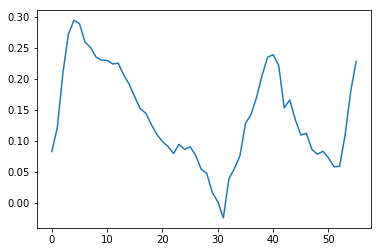

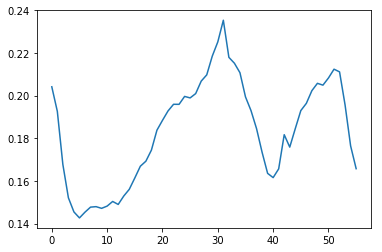

In [ ]:
plt.plot(R2_model2)
plt.show()
plt.plot(res_model2)

## *Conv3D*

In [ ]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, LSTM
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py


In [ ]:
## input layer
input_layer = Input(shape=(None, *x_train.shape[2:]))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding="same")(input_layer)
conv_layer2 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding="same")(conv_layer1)

## add max pooling to obtain the most imformatic features
#pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',padding="same")(conv_layer2)
conv_layer4 = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid',padding="same")(conv_layer3)
# pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
# out= LSTM(4)(conv_layer4)

# ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
# pooling_layer2 = BatchNormalization()(pooling_layer2)
# flatten_layer = Flatten()(pooling_layer2)

# ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
# ## add dropouts to avoid overfitting / perform regularization
# dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=conv_layer4)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, 256, 256,   0         
                             1)]                                 
                                                                 
 conv3d_12 (Conv3D)          (None, None, 256, 256, 8  224       
                             )                                   
                                                                 
 conv3d_13 (Conv3D)          (None, None, 256, 256, 8  1736      
                             )                                   
                                                                 
 conv3d_14 (Conv3D)          (None, None, 256, 256, 1  3472      
                             6)                                  
                                                                 
 conv3d_15 (Conv3D)          (None, None, 256, 256, 1  433 

In [ ]:
# model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.CosineSimilarity(axis=1)])
# model.predict(x=x_train, y=y_train, batch_size=5, epochs=20, validation_data=(x_test, y_test))
y_pred=model.predict(x=x_train)
y_pred.shape

(86, 4, 256, 256, 1)

## *Different ML Models Peninsular*

In [ ]:
# get the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [ ]:
#dataset loading and splitting between test and train
train_data = np.loadtxt("F:\Jyoti Shukla -MS\Peninsular dataset\Padded_Peninsular_Train_AVHRR_data_1981_2022.txt").reshape(1900,448,576)
test_data = np.loadtxt("F:\Jyoti Shukla -MS\Peninsular dataset\Padded_Peninsular_Test_AVHRR_data_1981_2022.txt").reshape(61,448,576)
X_train = train_data[:-1]
y_train = train_data[1:] #label is the next time step image
X_test = test_data[:-1]
y_test = test_data[1:]
print(train_data.shape,test_data.shape,train_data.max(),test_data.max())
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1900, 448, 576) (61, 448, 576) 100.0 100.0
(1899, 448, 576) (60, 448, 576) (1899, 448, 576) (60, 448, 576)


In [ ]:
# scaled data loading
paired_train = np.load("F:\Jyoti Shukla -MS\Peninsular dataset\paired_padded_peninsular_arrays_train_AVHRR_data.npz")
train_image, train_label = paired_train['x'],paired_train['y']
paired_test = np.load("F:\Jyoti Shukla -MS\Peninsular dataset\paired_padded_peninsular_arrays_test_AVHRR_data.npz")
test_image, test_label = paired_test['x'],paired_test['y']
train_image.shape,test_image.shape

((1899, 448, 576, 1), (60, 448, 576, 1))

In [ ]:
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test.reshape(448,576))
  unscaled = scaler.inverse_transform(mat.reshape(448,576))
  return unscaled


In [ ]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

In [ ]:
# train_image_set = train_image[:]
# train_label_set = train_label[:]
train_image_set = train_dataset[:]
train_label_set = train_labels[:]
train_image_flattened = train_image_set.reshape(1899,258048)
train_label_flattened = train_label_set.reshape(1899,258048)

In [ ]:
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_image_flattened,train_label_flattened)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model_KNN = KNeighborsRegressor()
model_KNN.fit(train_image_flattened,train_label_flattened)

KNeighborsRegressor()

In [ ]:
pred = model_KNN.predict(test_image[0].reshape(1,258048))
pred

array([[0., 0., 0., ..., 0., 0., 0.]])

0.9456818745923701


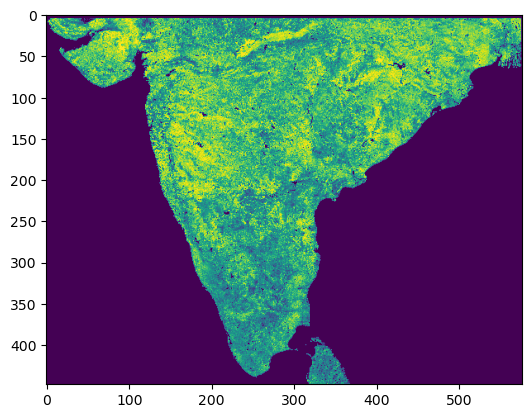

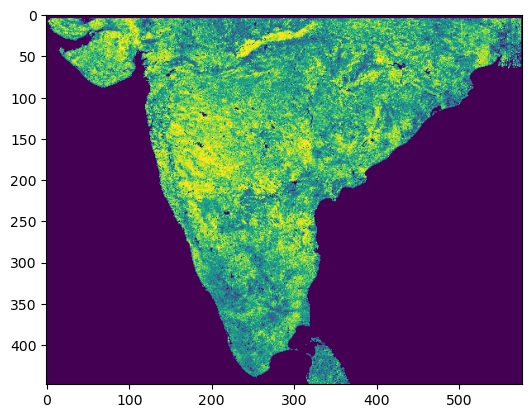

In [ ]:
from sklearn.metrics import r2_score
pred = pred.reshape(448,576)
yreal = test_image[0].reshape(448,576)
r2 = r2_score(yreal,pred)
print(r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)

Text(0.5, 0.98, 'KNN Outputs')

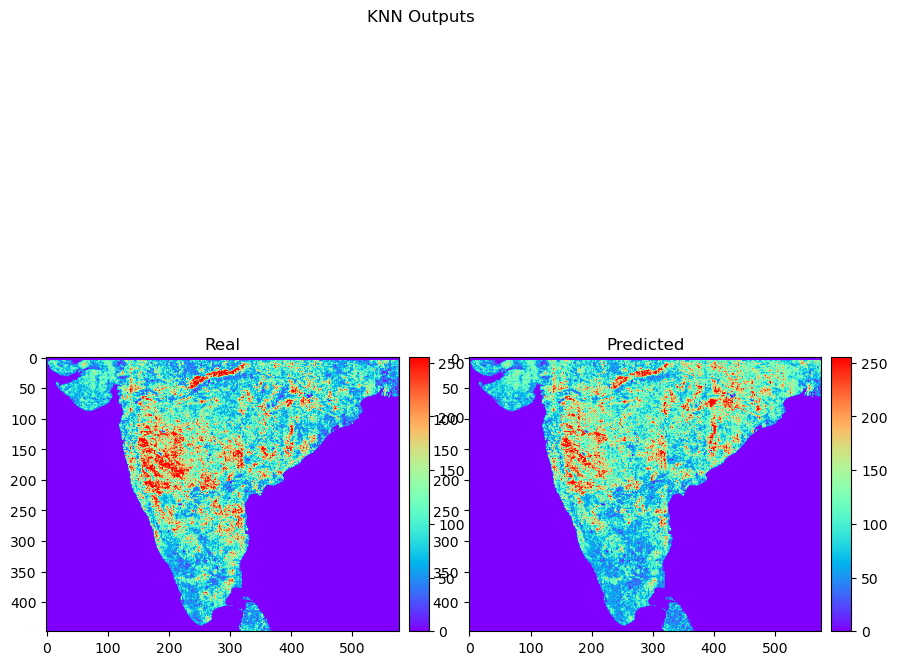

In [ ]:
unscale_pred = unscale(pred,y_test[0])
unscale_real = unscale(yreal,y_test[0])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(448,576), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("KNN Outputs")

In [ ]:
predicted_KNN = model_KNN.predict(test_image.reshape(60,258048))
predicted_KNN = predicted_KNN.reshape(60,448,576)
print(predicted_KNN.shape)
np.save("F:\Jyoti Shukla -MS\codes\Peninsular model outputs/predicted_output_KNN_peninsular.npy", predicted_KNN)

(60, 448, 576)


In [ ]:
R2_KNN =[]
error_KNN =[]
yhat_KNN =[]
MSE_KNN = []
for i in range(len(test_image)):
    pred = predicted_KNN[i].reshape(448,576)
    yreal = test_label[i].reshape(448,576)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal,pred)
    yhat_KNN.append(pred)
    R2_KNN.append(r2)
    error_KNN.append(err)
    MSE_KNN.append(mean_err)
print(R2_KNN)
np.save("F:\Jyoti Shukla -MS\codes\Peninsular model outputs/R2_score_KNN_peninsurlar.npy",R2_KNN)
np.save("F:\Jyoti Shukla -MS\codes\Peninsular model outputs/MAE_for_KNN_peninsurlar.npy",error_KNN)
np.save("F:\Jyoti Shukla -MS\codes\Peninsular model outputs\MSE_for_KNN_peninsurlar.npy",MSE_KNN)

[0.9455901863425963, 0.9209217225258549, 0.8995798210280763, 0.8972189804176627, 0.8943789835818782, 0.9120288353250837, 0.9163668258263894, 0.9116274954265466, 0.9115398857080265, 0.9097202779720226, 0.9009149379664253, 0.910568171415912, 0.8980380771600913, 0.8972188125622738, 0.9038742191369629, 0.9072975580290092, 0.9161761878259173, 0.9239839933791723, 0.930827525781344, 0.9381997644627743, 0.9430455757044136, 0.944484277013633, 0.9467052534040765, 0.9461966768076763, 0.9351340136801701, 0.9368506997571598, 0.9356283112023969, 0.9340753909542732, 0.9348050186600134, 0.9389740702927669, 0.9391191254978158, 0.9371138680004321, 0.9367249682302374, 0.937484307767553, 0.9378300437629024, 0.9442283629309787, 0.9518196232291056, 0.9395713799886225, 0.939573061602335, 0.9365047271695577, 0.9292256425589842, 0.9141616612904117, 0.8817237903841172, 0.8333473853797225, 0.881919446879997, 0.8322693641070291, 0.8781544208454549, 0.8899631463758614, 0.8869595207182174, 0.9068406276437749, 0.913

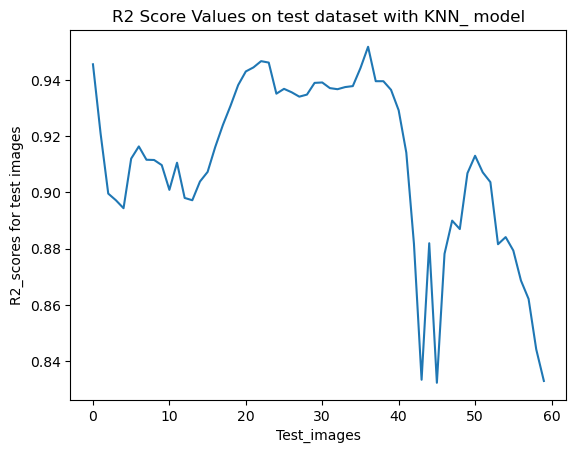

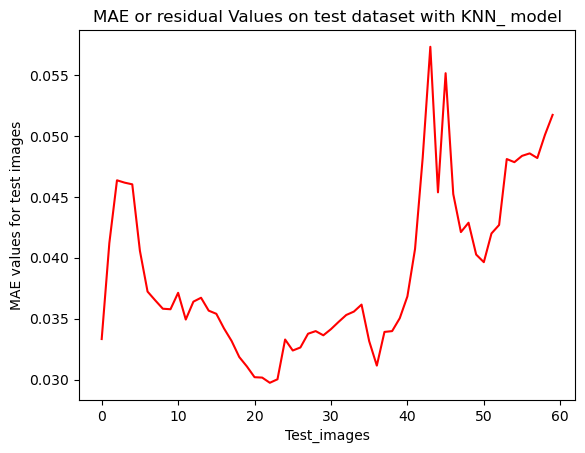

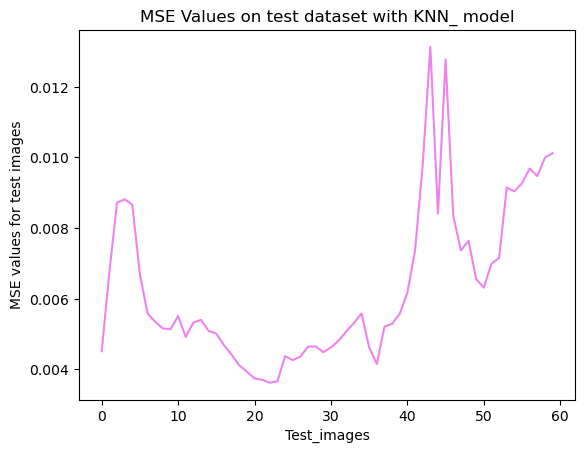

In [ ]:
R2_KNN_ = np.load("F:\Jyoti Shukla -MS\codes\Peninsular model outputs\R2_score_KNN_peninsurlar.npy")
error_KNN_ = np.load("F:\Jyoti Shukla -MS\codes\Peninsular model outputs\MAE_for_KNN_peninsurlar.npy")
MSE_KNN_ = np.load("F:\Jyoti Shukla -MS\codes\Peninsular model outputs\MSE_for_KNN_peninsurlar.npy")
plt.plot(R2_KNN_)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with KNN_ model")
plt.show()
plt.plot(error_KNN_,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with KNN_ model")
plt.show()
plt.plot(MSE_KNN_, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with KNN_ model")
plt.show()

In [ ]:
np.mean(R2_KNN_), np.max(R2_KNN_), np.mean(MSE_KNN_), np.mean(error_KNN_)

(0.9108868606717354,
 0.9518196232291056,
 0.006338566946302257,
 0.03882058072373317)

## *MLP*

In [ ]:
# mlp for multi-label classification
from numpy import mean
import numpy as np
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#dataset loading and splitting between test and train
train_data = np.loadtxt("F:\Jyoti Shukla -MS\karnataka dataset\Padded_Train_total_AVHRR_data_1981_2022.txt").reshape(2070,192,128)
test_data = np.loadtxt("F:\Jyoti Shukla -MS\karnataka dataset\Padded_Test_total_AVHRR_data_1981_2022.txt").reshape(53,192,128)
X_train = train_data[:-1]
y_train = train_data[1:] #label is the next time step image
X_test = test_data[:-1]
y_test = test_data[1:]
print(train_data.shape,test_data.shape,train_data.max(),test_data.max())
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2070, 192, 128) (53, 192, 128) 100.0 100.0
(2069, 192, 128) (52, 192, 128) (2069, 192, 128) (52, 192, 128)


In [ ]:
# scaled data loading
paired_train = np.load("F:\Jyoti Shukla -MS\Peninsular dataset\paired_padded_peninsular_arrays_train_AVHRR_data.npz")
train_image, train_label = paired_train['x'],paired_train['y']
paired_test = np.load("F:\Jyoti Shukla -MS\Peninsular dataset\paired_padded_peninsular_arrays_test_AVHRR_data.npz")
test_image, test_label = paired_test['x'],paired_test['y']
train_image.shape,test_image.shape

((1899, 448, 576, 1), (60, 448, 576, 1))

In [ ]:
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test.reshape(192,128))
  unscaled = scaler.inverse_transform(mat.reshape(192,128))
  return unscaled


In [ ]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

# Parameters
batch_size = 8 # It is the sample size of inputs to be processed at each training stage.
hidden_units = 256
dropout = 0.2
input_size = 258048

# Nossa  MLP com ReLU e Dropout
model = Sequential()

model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(258048))
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss='mae', optimizer='sgd', metrics=['mse'])

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [ ]:
train_image_set = train_image[:]
train_label_set = train_label[:]
train_image_flattened = train_image_set.reshape(1899,258048)
train_label_flattened = train_label_set.reshape(1899,258048)
x_train = train_image_flattened
y_train = train_label_flattened
test_image_set = test_image[:]
test_label_set = test_label[:]
X_test, y_test = test_image_set.reshape(60,258048),test_label_set.reshape(60,258048)


In [ ]:
history = model.fit(x_train, y_train, epochs=300, batch_size=batch_size)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
from tensorflow.keras.callbacks import History
history.history.keys()
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MLP_history_300_epochs_total.npy",history.history)

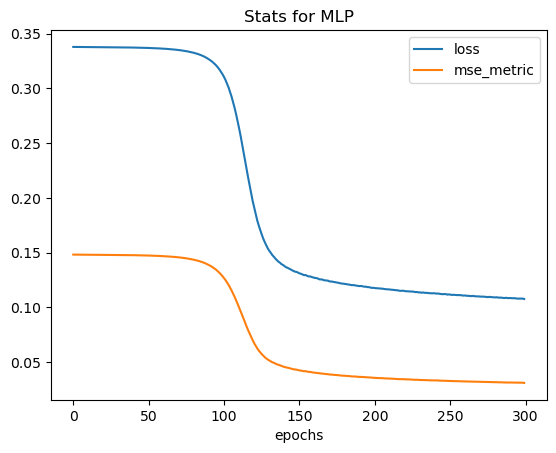

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['mse'])
# plt.plot(history['val_loss'])
# plt.plot(history['val_mean_squared_error'])

plt.title('Stats for MLP')
plt.xlabel('epochs')
plt.legend(['loss','mse_metric'])
plt.show()

In [ ]:
_, mse = model.evaluate(X_test, y_test)
print(mse)

2/2 [==============================] - 0s 7ms/step - loss: 0.0837 - mse: 0.0201
0.020133601501584053


In [ ]:
predicted_MLP = model.predict(X_test)
predicted_MLP = predicted_MLP.reshape(52,192,128)
print(predicted_MLP.shape)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/predicted_output_MLP_total.npy",predicted_MLP)

(52, 192, 128)


0.8048164772524452


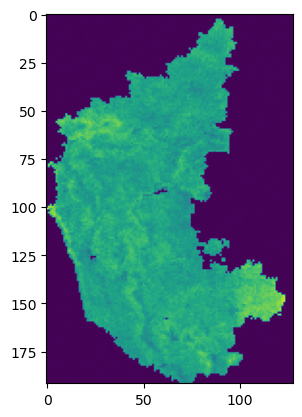

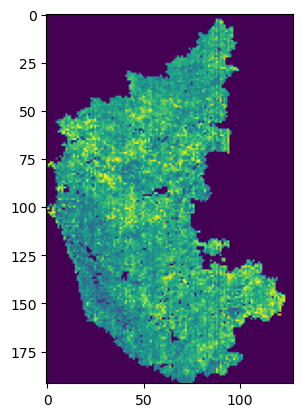

In [ ]:
from sklearn.metrics import r2_score
predicted_MLP = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/predicted_output_MLP_total.npy")
pred = predicted_MLP[6].reshape(192,128)
yreal = test_label[6].reshape(192,128)
r2 = r2_score(yreal,pred)
print(r2)
plt.imshow(predicted_MLP[6].reshape(192,128))
plt.show()
plt.imshow(test_label[6].reshape(192,128))

In [ ]:
unscale_pred = unscale(pred,y_test[6])
unscale_real = unscale(yreal,y_test[6])
print(np.unique(unscale_pred),np.unique(unscale_real))

[4.6281191e-03 4.6699275e-03 5.2317195e-03 ... 7.5213814e+01 7.5382141e+01
 7.6464981e+01] [  0.          6.5423036  13.064225  ...  99.75       99.99999
 100.       ]


[4.6281191e-03 4.6699275e-03 5.2317195e-03 ... 7.5213814e+01 7.5382141e+01
 7.6464981e+01] [  0.          6.5423036  13.064225  ...  99.75       99.99999
 100.       ]


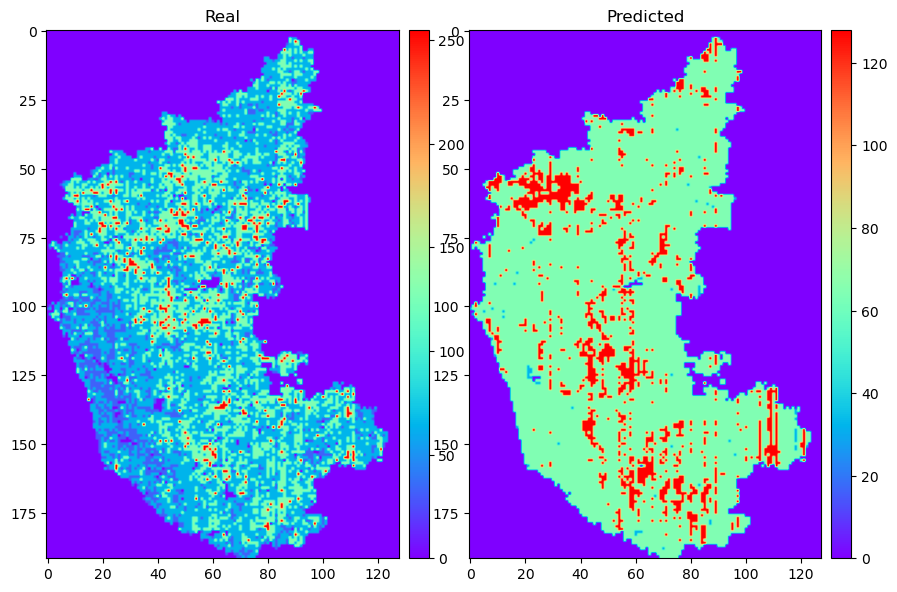

In [ ]:
unscale_pred = unscale(pred,y_test[6])
unscale_real = unscale(yreal,y_test[6])
print(np.unique(unscale_pred),np.unique(unscale_real))
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax[i].axis("off")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
R2_MLP=[]
res_MLP=[]
for i in range(len(predicted_MLP)):
    r2 = r2_score(y_test[i].reshape(192,128),predicted_MLP[i].reshape(192,128))
    R2_MLP.append(r2)
    residual = mae(y_test[i].reshape(192,128),predicted_MLP[i].reshape(192,128))
    res_MLP.append(residual)
print(R2_MLP)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_MLP_total.npy",R2_MLP)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_MLP_total.npy",res_MLP)

[0.796788558758266, 0.7968941846733912, 0.7971775748023479, 0.7940601132455172, 0.7858686039583456, 0.7928702688580946, 0.8048164772524452, 0.7975845787775049, 0.7825077562346401, 0.7682985771767521, 0.7652287169570604, 0.7584135639202556, 0.7506998385762926, 0.7449042021872181, 0.7455446969863275, 0.7437384468947562, 0.7516406056203209, 0.7571728223102491, 0.7595969046746472, 0.759251606374424, 0.7637700786313779, 0.7596217781392635, 0.7509965494686761, 0.7468645714182442, 0.7308132523314832, 0.7206329340660278, 0.7082854238239167, 0.7426230750289896, 0.7445483424090211, 0.7495408919463896, 0.7535724125027417, 0.7526632304905949, 0.751483819162253, 0.7488837239969641, 0.7458363799031877, 0.7480538649686058, 0.7489167609687024, 0.7597259222020485, 0.7608450140269525, 0.766931562376429, 0.7732322323601769, 0.7754900815000793, 0.7775441708397237, 0.7779664046339305, 0.7801908188106054, 0.7801114344562767, 0.7765632864660672, 0.7753455540086877, 0.7898324929181009, 0.8045225686523421, 0.8

In [ ]:
from sklearn.metrics import mean_squared_error as mse
predicted_MLP = np.load("F:\Jyoti Shukla -MS\codes\Different model output total\predicted_output_MLP_total.npy")
MSE_MLP =[]
for i in range(len(predicted_MLP)):
    # r2 = r2_score(y_test[i].reshape(192,128),predicted_MLP[i].reshape(192,128))
    # R2_MLP.append(r2)
    residual = mse(test_label[i].reshape(192,128),predicted_MLP[i].reshape(192,128))
    MSE_MLP.append(residual)
print(MSE_MLP)
#np.save("F:\Jyoti Shukla -MS\codes\AVHRR codes/R2_score_MLP.npy",R2_MLP)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_MLP_total.npy",MSE_MLP)

[0.012778851, 0.012652222, 0.012676146, 0.012831269, 0.013173685, 0.012845809, 0.012189591, 0.012734685, 0.0141867865, 0.015462687, 0.016605271, 0.017774155, 0.018875182, 0.020000787, 0.021161053, 0.021952404, 0.021733427, 0.021644888, 0.02154918, 0.021925945, 0.021380778, 0.021994913, 0.023516633, 0.024646802, 0.027736876, 0.029828671, 0.03278896, 0.026584338, 0.026399404, 0.025601093, 0.024439737, 0.02392307, 0.023221666, 0.022010181, 0.021039244, 0.0205907, 0.020999543, 0.02136428, 0.020213244, 0.020483192, 0.020593414, 0.02092643, 0.021010246, 0.021176893, 0.021007277, 0.021231193, 0.021837391, 0.021891939, 0.018786445, 0.01573003, 0.014750525, 0.014488065]


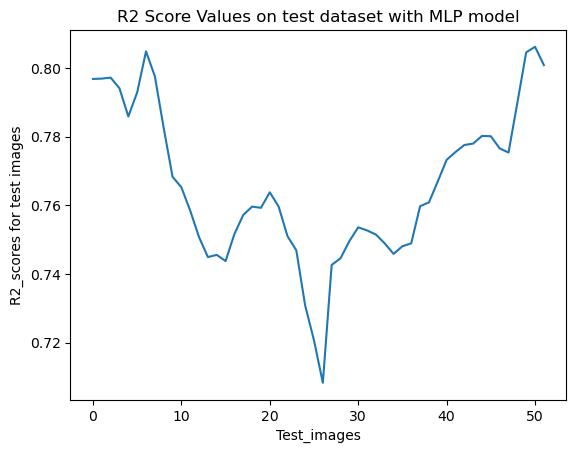

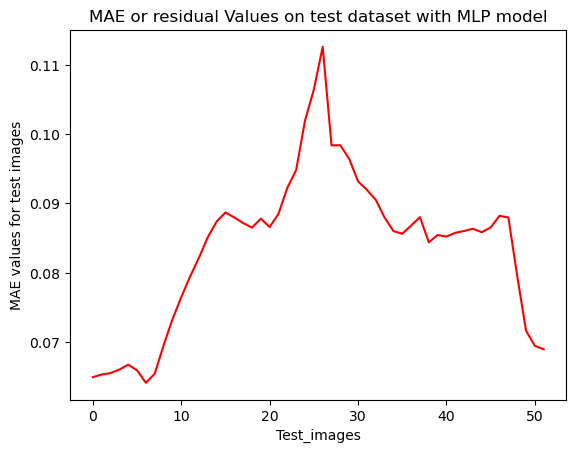

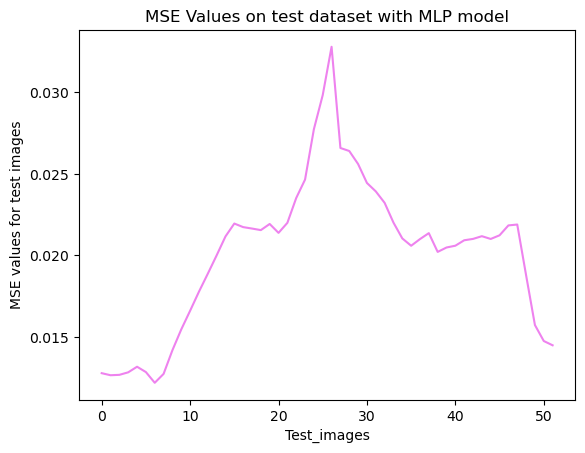

In [ ]:
R2_MLP = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_MLP_total.npy")
error_MLP = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_MLP_total.npy")
MSE_MLP = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_MLP_total.npy")
#print(error)
plt.plot(R2_MLP)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with MLP model")
plt.show()
plt.plot(error_MLP,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with MLP model")
plt.show()
plt.plot(MSE_MLP, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with MLP model")
#plt.legend(["MAE","MSE"])
plt.show()

In [ ]:
np.mean(R2_MLP), np.max(R2_MLP), np.mean(MSE_MLP), np.mean(error_MLP)

(0.7658740437715117, 0.8061615687411368, 0.020133602, 0.08373035)

## *MSVR*

In [ ]:
"""
Multi-output Support Vector Regression
"""
# Copyright (C) 2020 Xinze Zhang, Kaishuai Xu, Siyue Yang, Yukun Bao
# <xinze@hust.edu.cn>, <xu.kaishuai@gmail.com>, <siyue_yang@hust.edu.cn>, <yukunbao@hust.edu.cn>

# This program is free software: you can redistribute it and/or modify
# it under the terms of the Apache.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# Apache License for more details.


import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

In [ ]:
msvr = MSVR()
msvr.fit(train_image_flattened,train_label_flattened)

MemoryError: Unable to allocate 496. GiB for an array with shape (258048, 258048) and data type float64

In [ ]:
predicted_MSVR = msvr.predict(test_image.reshape(60,24576))
predicted_MSVR = predicted_MSVR.reshape(60,192,128)
print(predicted_MSVR.shape)
np.save("F:\Jyoti Shukla -MS\codes\AVHRR codes/Predicted_outputs_SVR.npy", predicted_MSVR)

(60, 192, 128)


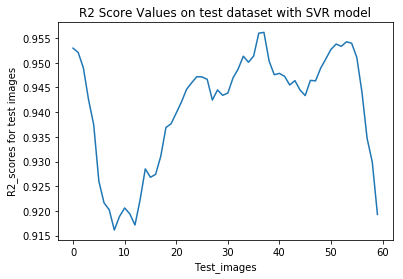

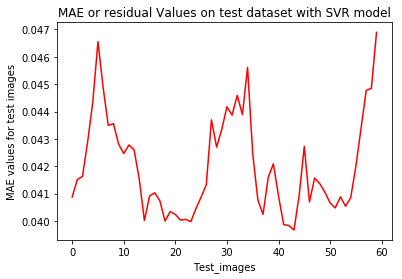

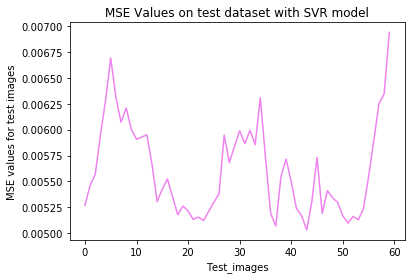

In [ ]:
R2_MSVR = np.load("R2_score_SVR.npy")
error_MSVR = np.load("MAE_for_SVR.npy")
MSE_MSVR = np.load("MSE_for_SVR.npy")
#print(error)
plt.plot(R2_MSVR)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with SVR model")
plt.show()
plt.plot(error_MSVR,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with SVR model")
plt.show()
plt.plot(MSE_MSVR, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with SVR model")
#plt.legend(["MAE","MSE"])
plt.show()

# BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
# choose a number of time steps
n_steps = 2
# split into samples
traindata = np.reshape(train_dataset, (1899,258048))
trainlabel =  np.reshape(train_labels,(1899,258048) )
X, y = split_sequence(traindata, n_steps)
print(X.shape, y.shape)
n_steps = 2
testdata = np.reshape(test_dataset, (60,258048))
testlabel =  np.reshape(test_labels,(60,258048) )
XTest, YTest = split_sequence(testdata, n_steps)
print(XTest.shape, YTest.shape)
n_features = XTest.shape[2]
XTest = XTest.reshape((XTest.shape[0], XTest.shape[1], n_features))

(1897, 2, 258048) (1897, 258048)
(58, 2, 258048) (58, 258048)


In [ ]:
n_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
    # Input layer
model.add(Bidirectional(LSTM(units = 50, return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(units = 1200, return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(units = 200)))
model.add(Dense(n_features))
#Compile model
model.compile(optimizer='adam',loss='mae',metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 100)            103239600 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2, 2400)           12489600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               4161600   
_________________________________________________________________
dense (Dense)                (None, 258048)            103477248 
Total params: 223,368,048
Trainable params: 223,368,048
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# early_stop = keras.callbacks.EarlyStopping(monitor = ‘val_loss’,
#                                                patience = 10)
history = model.fit(X, y, epochs=30, validation_data=(XTest, YTest), verbose=2)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/BiLSTM_AVHRR_model_peninsular_history.npy", history.history)
model.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/BiLSTM_AVHRR_model_peninsular.h5")

Epoch 1/30
60/60 - 20s - loss: 0.2018 - mse: 0.1156 - val_loss: 0.1058 - val_mse: 0.0319
Epoch 2/30
60/60 - 6s - loss: 0.0788 - mse: 0.0196 - val_loss: 0.0837 - val_mse: 0.0229
Epoch 3/30
60/60 - 6s - loss: 0.0751 - mse: 0.0187 - val_loss: 0.0799 - val_mse: 0.0213
Epoch 4/30
60/60 - 6s - loss: 0.0743 - mse: 0.0186 - val_loss: 0.0814 - val_mse: 0.0222
Epoch 5/30
60/60 - 6s - loss: 0.0744 - mse: 0.0188 - val_loss: 0.0834 - val_mse: 0.0230
Epoch 6/30
60/60 - 6s - loss: 0.0743 - mse: 0.0187 - val_loss: 0.0786 - val_mse: 0.0210
Epoch 7/30
60/60 - 6s - loss: 0.0736 - mse: 0.0186 - val_loss: 0.0785 - val_mse: 0.0212
Epoch 8/30
60/60 - 6s - loss: 0.0734 - mse: 0.0186 - val_loss: 0.0792 - val_mse: 0.0215
Epoch 9/30
60/60 - 6s - loss: 0.0733 - mse: 0.0186 - val_loss: 0.0793 - val_mse: 0.0215
Epoch 10/30
60/60 - 6s - loss: 0.0733 - mse: 0.0186 - val_loss: 0.0771 - val_mse: 0.0205
Epoch 11/30
60/60 - 6s - loss: 0.0732 - mse: 0.0186 - val_loss: 0.0775 - val_mse: 0.0208
Epoch 12/30
60/60 - 6s - loss

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_BiLSTM = load_model(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/BiLSTM_AVHRR_model_peninsular.h5")
history_BiLSTM = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/BiLSTM_AVHRR_model_peninsular_history.npy",allow_pickle=True).item()
history_BiLSTM.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

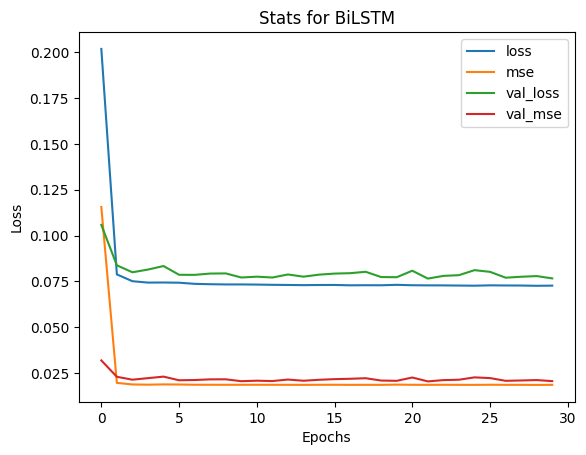

In [ ]:
# Results of updated model6

plt.plot(history_BiLSTM['loss'])
plt.plot(history_BiLSTM['mse'])
plt.plot(history_BiLSTM['val_loss'])
plt.plot(history_BiLSTM['val_mse'])

plt.title('Stats for BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','mse','val_loss','val_mse'])
plt.show()

In [ ]:
framed = XTest[4]
(np.expand_dims(framed, axis=0)).shape

(1, 2, 49152)

(1, 258048)
0.732285832149148


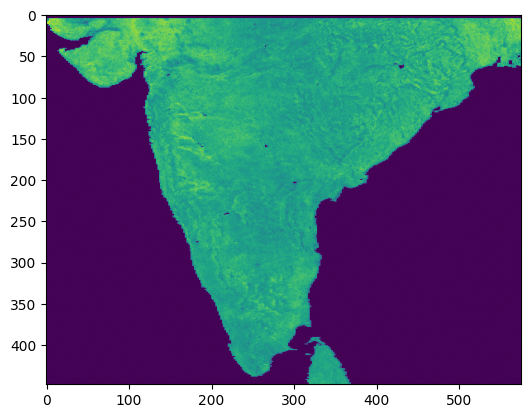

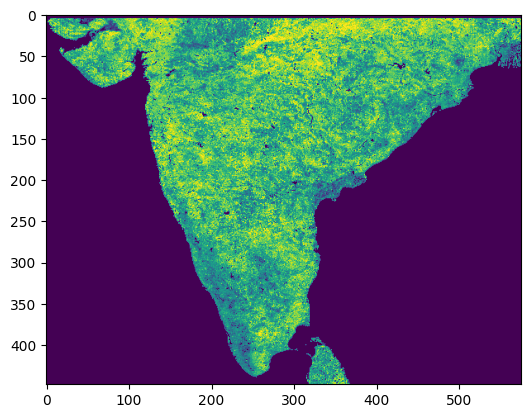

In [ ]:
model = model_BiLSTM
from sklearn.metrics import r2_score
framed = XTest[4]
pred = model.predict(np.expand_dims(framed, axis=0))
print(pred.shape)
y_real = YTest[4].reshape(448,576)
pred = pred.reshape(448,576)
r2 = r2_score(y_real,pred)
print(r2)
plt.imshow(pred.reshape(448,576))
plt.figure()
plt.imshow(y_real.reshape(448,576))

In [ ]:
# data_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_test_total_AVHRR_data_1981_2022.npz")
# test_data, test_label = data_test[0], data_test[1]
#print(test_data.shape, test_label.shape)
print(test_data_rfvhi.shape)
# vhi_train, vhi_train_label, n_steps = split_sequence(train_data, 4)
vhi_test, vhi_test_label, n_steps = split_sequence(rf_vhi_test, test_data_rfvhi, 2)
# print("Training Dataset Shapes: " + str(vhi_train.shape) + ", " + str(vhi_train_label.shape))
print("Validation Dataset Shapes: " + str(vhi_test.shape) + ", " + str(vhi_test_label.shape))

In [ ]:
pred = pred.reshape(192,128,1)
y_real = y_real.reshape(192,128,1)
unscale_pred = unscale(pred,vhi_test_label[4])
unscale_real = unscale(y_real,vhi_test_label[4])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("1D- CNN Outputs")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = XTest
label = YTest
predicted_mod =[]
true = []
R2_mod =[]
res_mod = []
mse_mod =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i]
    y_real = label[i].reshape(448,576)
    # test = framed.reshape(1,1,448,576,1)
    pred = model.predict(np.expand_dims(framed, axis=0))
    pred = pred.reshape(448,576)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_mod.append(residual)
    err = mse(y_real,pred)
    mse_mod.append(err)
    predicted_mod.append(pred)
    true.append(y_real)
    R2_mod.append(r2)

np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_bilstm_peninsular.npy", R2_mod)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_bilstm_peninsular.npy",res_mod)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_bilstm_peninsular.npy",mse_mod)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/Predicted_outputs_bilstm_peninsular.npy", predicted_mod)
# r2 = r2_score(y_real, pred)
print(len(R2_mod))
print('r2 score for test data on model is: \n', R2_mod)

58
r2 score for test data on model is: 
 [0.6925802624586028, 0.6874785040052643, 0.6918660859478463, 0.7037397065416424, 0.732285832149148, 0.760543824272002, 0.7677335379693532, 0.7671402954330154, 0.7653312041191246, 0.7565150995901022, 0.7430478768689976, 0.7321589822813053, 0.7258135068040042, 0.7337293862446648, 0.7412660991944895, 0.7431139088212554, 0.7432982549379958, 0.749151601899577, 0.7464609745419042, 0.7366037247520374, 0.7252635131327216, 0.7146255202932411, 0.7095531807400657, 0.7092435941875674, 0.7100108050447103, 0.7138447250289992, 0.7178460512067715, 0.7188295739005747, 0.7201890096367296, 0.7180661834502152, 0.7132697791440462, 0.701228429384807, 0.6889011948758954, 0.6744414216511513, 0.6849532777275837, 0.6828180415311529, 0.6812134300085193, 0.6866349388241643, 0.6923271285038174, 0.6977384373658039, 0.7062119255698351, 0.7136417465987391, 0.7135638057226753, 0.7042596589210245, 0.7029389083006374, 0.6853864149500997, 0.6802303439795637, 0.6815218957754587, 0.

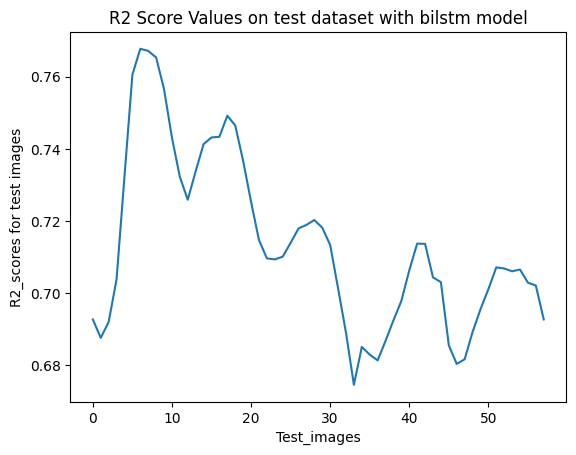

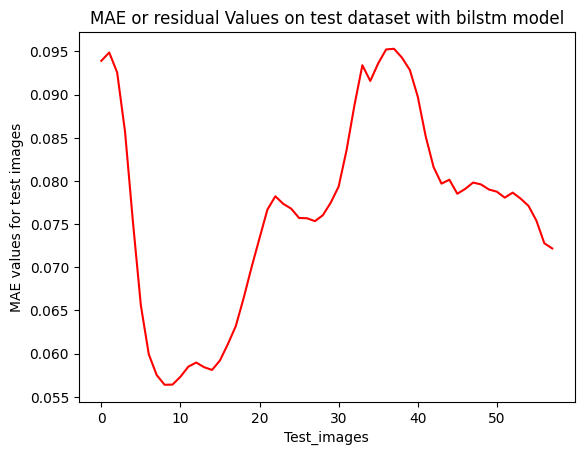

Text(0.5, 1.0, 'MSE Values on test dataset with bilstm model')

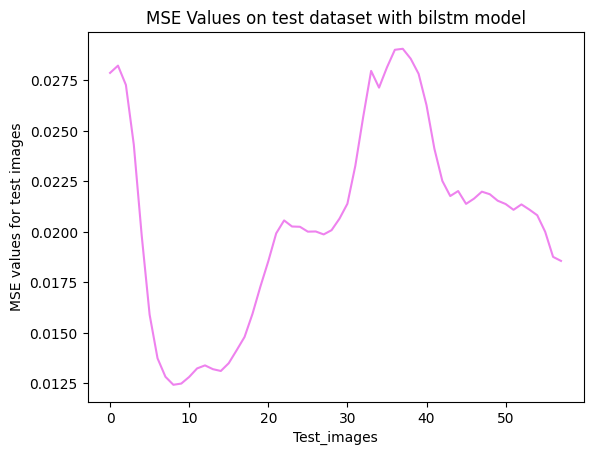

In [ ]:
R2 = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_bilstm_peninsular.npy")
res = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_bilstm_peninsular.npy")
MSE = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_bilstm_peninsular.npy")
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with bilstm model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with bilstm model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with bilstm model")

In [ ]:
np.mean(R2), np.max(R2), np.mean(MSE), np.mean(res)

(0.7134067699197049,
 0.7677335379693532,
 0.02056259799903511,
 0.07660144354553147)

# 1D-CNN
dataset same as bilstm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
# choose a number of time steps
n_steps = 2
# split into samples
traindata = np.reshape(train_dataset, (1899,258048))
trainlabel =  np.reshape(train_labels,(1899,258048) )
X, y = split_sequence(traindata, n_steps)
print(X.shape, y.shape)
n_steps = 2
testdata = np.reshape(test_dataset, (60,258048))
testlabel =  np.reshape(test_labels,(60,258048) )
XTest, YTest = split_sequence(testdata, n_steps)
print(XTest.shape, YTest.shape)
n_features = XTest.shape[2]
XTest = XTest.reshape((XTest.shape[0], XTest.shape[1], n_features))

(1897, 2, 258048) (1897, 258048)
(58, 2, 258048) (58, 258048)


In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# define model
n_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
# model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=1000, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
model.add(Flatten())
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(n_features))
# huber_loss = tf.keras.losses.Huber(delta=0.15)
model.compile(optimizer='adam', loss='mae', metrics=['mse'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 64)             33030208  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 1000)           129000    
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                100050    
_________________________________________________________________
dense_1 (Dense)              (None, 258048)            13160448  
Total params: 46,419,706
Trainable params: 46,419,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
history= model.fit(X, y, epochs=40, validation_data=(XTest, YTest), verbose=2)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/1dcnn_AVHRR_model_peninsular_history.npy", history.history)
model.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/1dcnn_AVHRR_model_peninsular.h5")
# demonstrate prediction

Epoch 1/40
60/60 - 11s - loss: 0.1106 - mse: 0.0437 - val_loss: 0.0804 - val_mse: 0.0218
Epoch 2/40
60/60 - 4s - loss: 0.0738 - mse: 0.0185 - val_loss: 0.0783 - val_mse: 0.0208
Epoch 3/40
60/60 - 4s - loss: 0.0738 - mse: 0.0186 - val_loss: 0.0793 - val_mse: 0.0213
Epoch 4/40
60/60 - 4s - loss: 0.0738 - mse: 0.0186 - val_loss: 0.0795 - val_mse: 0.0213
Epoch 5/40
60/60 - 4s - loss: 0.0738 - mse: 0.0186 - val_loss: 0.0783 - val_mse: 0.0208
Epoch 6/40
60/60 - 4s - loss: 0.0739 - mse: 0.0186 - val_loss: 0.0786 - val_mse: 0.0210
Epoch 7/40
60/60 - 4s - loss: 0.0739 - mse: 0.0186 - val_loss: 0.0786 - val_mse: 0.0210
Epoch 8/40
60/60 - 4s - loss: 0.0739 - mse: 0.0186 - val_loss: 0.0797 - val_mse: 0.0215
Epoch 9/40
60/60 - 4s - loss: 0.0740 - mse: 0.0186 - val_loss: 0.0804 - val_mse: 0.0218
Epoch 10/40
60/60 - 4s - loss: 0.0740 - mse: 0.0186 - val_loss: 0.0811 - val_mse: 0.0223
Epoch 11/40
60/60 - 4s - loss: 0.0739 - mse: 0.0186 - val_loss: 0.0790 - val_mse: 0.0211
Epoch 12/40
60/60 - 4s - loss

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_1dcnn = load_model(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/1dcnn_AVHRR_model_peninsular.h5")
history_1dcnn = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/1dcnn_AVHRR_model_peninsular_history.npy",allow_pickle=True).item()
history_1dcnn.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

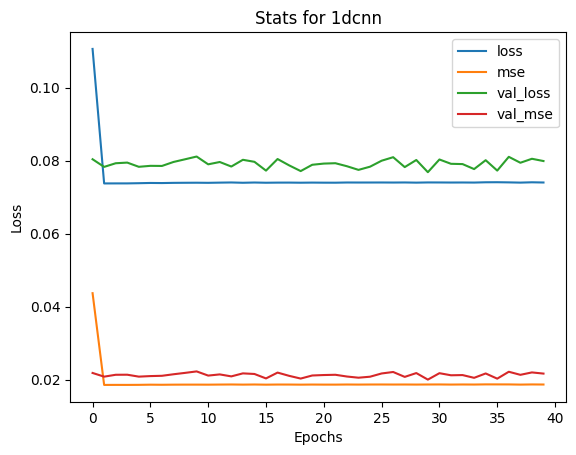

In [ ]:
# Results of updated model6

plt.plot(history_1dcnn['loss'])
plt.plot(history_1dcnn['mse'])
plt.plot(history_1dcnn['val_loss'])
plt.plot(history_1dcnn['val_mse'])

plt.title('Stats for 1dcnn')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','mse','val_loss','val_mse'])
plt.show()

In [ ]:
framed = XTest[4]
(np.expand_dims(framed, axis=0)).shape

(1, 2, 258048)

(1, 258048)
0.7127956300693429


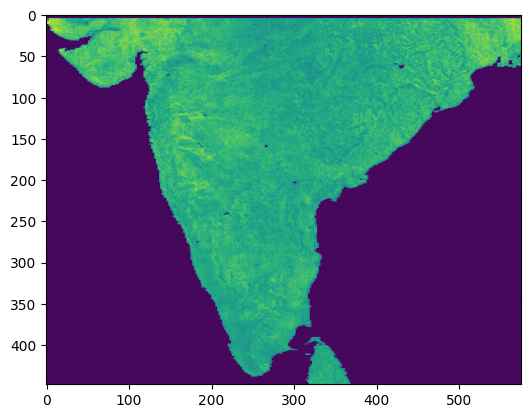

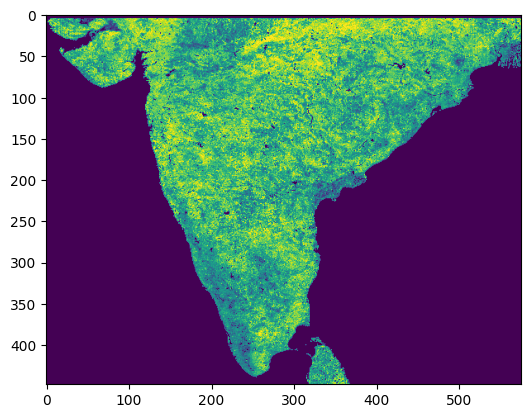

In [ ]:
model = model_1dcnn
from sklearn.metrics import r2_score
framed = XTest[4]
pred = model.predict(np.expand_dims(framed, axis=0))
print(pred.shape)
y_real = YTest[4].reshape(448,576)
pred = pred.reshape(448,576)
r2 = r2_score(y_real,pred)
print(r2)
plt.imshow(pred.reshape(448,576))
plt.figure()
plt.imshow(y_real.reshape(448,576))

In [ ]:
# data_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_test_total_AVHRR_data_1981_2022.npz")
# test_data, test_label = data_test[0], data_test[1]
#print(test_data.shape, test_label.shape)
print(test_data_rfvhi.shape)
# vhi_train, vhi_train_label, n_steps = split_sequence(train_data, 4)
vhi_test, vhi_test_label, n_steps = split_sequence(rf_vhi_test, test_data_rfvhi, 2)
# print("Training Dataset Shapes: " + str(vhi_train.shape) + ", " + str(vhi_train_label.shape))
print("Validation Dataset Shapes: " + str(vhi_test.shape) + ", " + str(vhi_test_label.shape))

In [ ]:
pred = pred.reshape(192,128,1)
y_real = y_real.reshape(192,128,1)
unscale_pred = unscale(pred,vhi_test_label[4])
unscale_real = unscale(y_real,vhi_test_label[4])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("1D- CNN Outputs")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = XTest
label = YTest
predicted_mod =[]
true = []
R2_mod =[]
res_mod = []
mse_mod =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i]
    y_real = label[i].reshape(448,576)
    # test = framed.reshape(1,1,448,576,1)
    pred = model.predict(np.expand_dims(framed, axis=0))
    pred = pred.reshape(448,576)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_mod.append(residual)
    err = mse(y_real,pred)
    mse_mod.append(err)
    predicted_mod.append(pred)
    true.append(y_real)
    R2_mod.append(r2)

np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_1dcnn_peninsular.npy", R2_mod)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_1dcnn_peninsular.npy",res_mod)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_1dcnn_peninsular.npy",mse_mod)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/Predicted_outputs_1dcnn_peninsular.npy", predicted_mod)
# r2 = r2_score(y_real, pred)
print(len(R2_mod))
print('r2 score for test data on model is: \n', R2_mod)

58
r2 score for test data on model is: 
 [0.6666493274752472, 0.6613809806191782, 0.6666940215586682, 0.6809637819197838, 0.7127956300693429, 0.744693168164294, 0.7547244129687791, 0.755561823461712, 0.7559948106875036, 0.7504299823774119, 0.739937901076668, 0.732087658334785, 0.727669090722983, 0.7341913387480378, 0.7397094590098491, 0.739685515758534, 0.7371136913058507, 0.7396162573666459, 0.7340170897486465, 0.723643084444208, 0.7129706342127287, 0.7028026557497928, 0.699136660036809, 0.700917109690853, 0.7023425642064743, 0.7060150351837687, 0.7093878815391571, 0.7111190978877251, 0.7123917619911112, 0.7100889593001668, 0.705016765189474, 0.6912171747210201, 0.6754918692488758, 0.6586366582150232, 0.6657183458569436, 0.6611151766953165, 0.6581423220060493, 0.6634799899423653, 0.6694232509943084, 0.6753872742021163, 0.6853005028749987, 0.6956975310932905, 0.6989805236288542, 0.6944994606374748, 0.6924996711703639, 0.6816440479658691, 0.6778087768798036, 0.6784612031920726, 0.685074

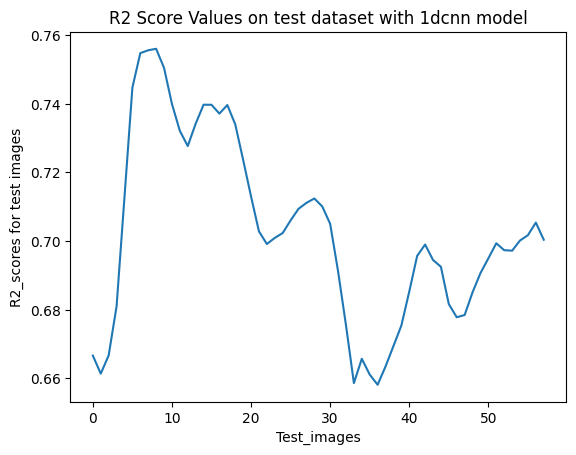

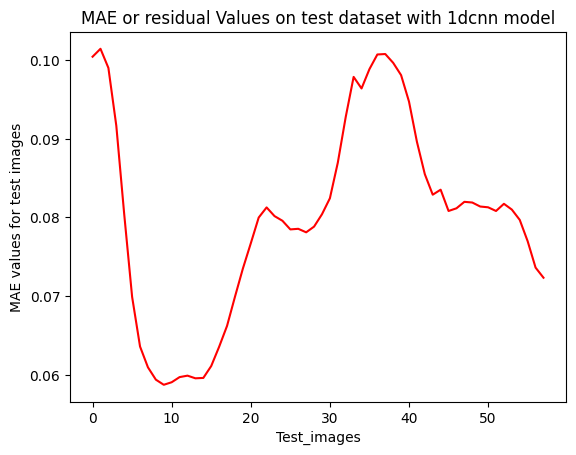

Text(0.5, 1.0, 'MSE Values on test dataset with 1dcnn model')

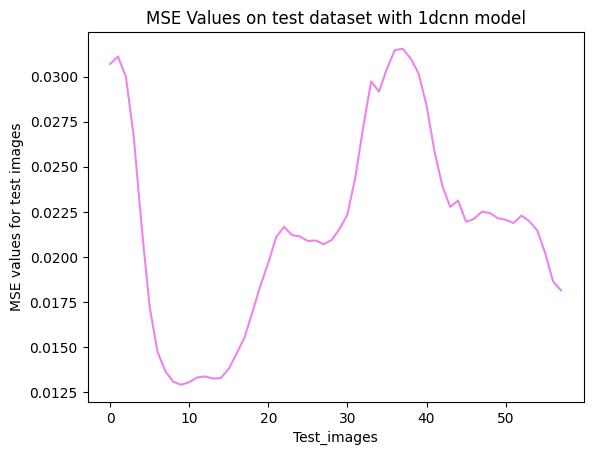

In [ ]:
R2 = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_1dcnn_peninsular.npy")
res = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_1dcnn_peninsular.npy")
MSE = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_1dcnn_peninsular.npy")
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with 1dcnn model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with 1dcnn model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with 1dcnn model")

In [ ]:
np.mean(R2), np.max(R2), np.mean(MSE), np.mean(res)

(0.7028533838191537,
 0.7559948106875036,
 0.02165425575720799,
 0.07990793403448132)

# XGBoost

In [ ]:
import xgboost as xg
# Instantiation
xgbr = xg.XGBRegressor(max_depth = 2, booster ='gbtree',objective='reg:squarederror',
                  n_estimators = 2, n_jobs= -1, random_state = 0, verbosity =1)
xgbr.fit(train_image_flattened, train_label_flattened)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=0, ...)

In [ ]:
test_image_flattened = test_dataset.reshape(60,258048)
predicted_xgb = xgbr.predict(test_image_flattened)
predicted_xgb = predicted_xgb.reshape(60,448,576)
print(predicted_xgb.shape)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/Predicted_outputs_xgboost_peninsular.npy", predicted_xgb)

(60, 448, 576)


0.20338318504044067 0.3001997853942055


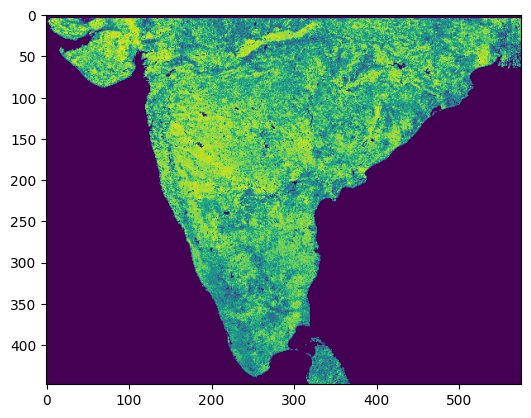

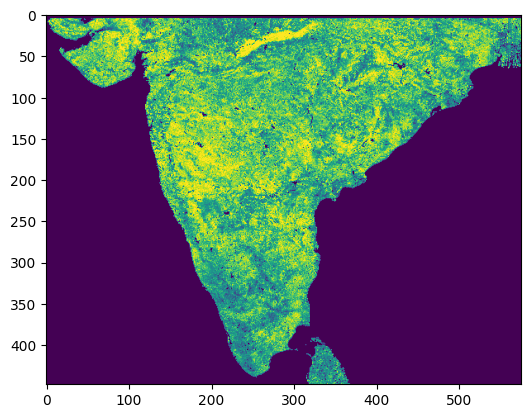

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
predicted_xgb = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/Predicted_outputs_xgboost_peninsular.npy")
pred = predicted_xgb[0].reshape(448,576)
yreal = test_labels[0].reshape(448,576)
r2 = r2_score(yreal,pred)
error = mae(yreal,pred)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)

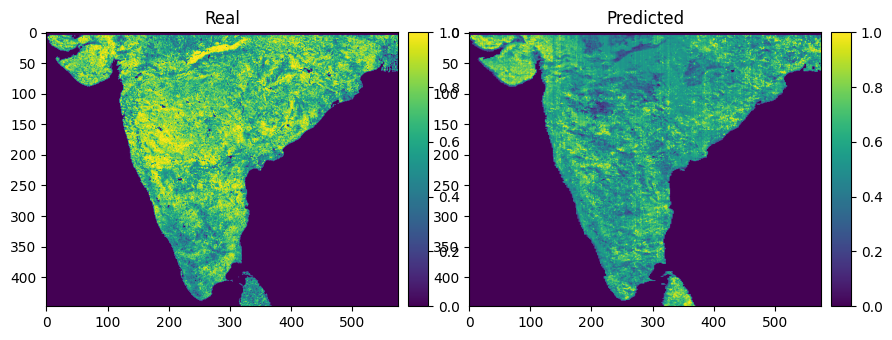

In [ ]:
images = [yreal, pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(448,576))
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

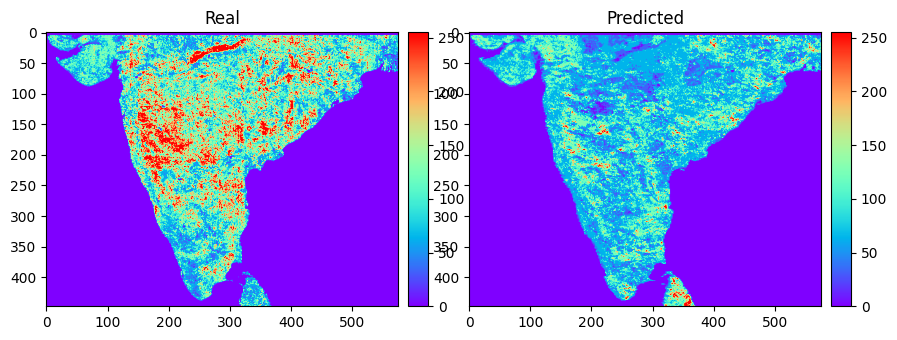

In [ ]:
unscale_pred = unscale(pred,y_test[0])
unscale_real = unscale(yreal,y_test[0])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(448,576), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
R2_xgb =[]
error_xgb =[]
yhat_xgb =[]
MSE_xgb = []
for i in range(len(test_dataset)):
    pred = predicted_xgb[i].reshape(448,576)
    yreal = test_labels[i].reshape(448,576)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mse_err = mse(yreal,pred)
    yhat_xgb.append(pred)
    R2_xgb.append(r2)
    MSE_xgb.append(mse_err)
    error_xgb.append(err)
print(R2_xgb)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_xgb_peninsular.npy", R2_xgb)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_xgb_peninsular.npy", error_xgb)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_xgb_peninsular.npy", MSE_xgb)

[0.3001997853942055, 0.31745233549964263, 0.27498080268427105, 0.2739786607555865, 0.24689074991726934, 0.233418315959303, 0.2629522311713931, 0.21693369620385017, 0.14176763451763102, 0.11994090988624438, 0.08834810714951896, 0.054874785993259484, 0.06998699636552416, 0.02681037339067169, 0.03994473063020429, 0.05481212342222111, 0.07274287896902121, 0.10158833274460684, 0.19414649429850314, 0.2322505920461952, 0.2544887078972089, 0.26205860883110116, 0.26210199114645527, 0.2649562174160599, 0.2572203608274285, 0.26087762408807275, 0.2618161099117302, 0.27121165240780637, 0.2807890866682862, 0.29217888402308806, 0.303107433421642, 0.3145625716111411, 0.31847173343924623, 0.33712650825233115, 0.3455233647217539, 0.3408649350034739, 0.35922793034879497, 0.361552453821143, 0.36397973964537145, 0.3603604013614259, 0.3500908120792292, 0.3405652522446584, 0.3122006707570884, 0.2667824485051324, 0.21398572089475476, 0.19381220313616393, 0.1455851878484584, 0.13800945837947703, 0.136902294798

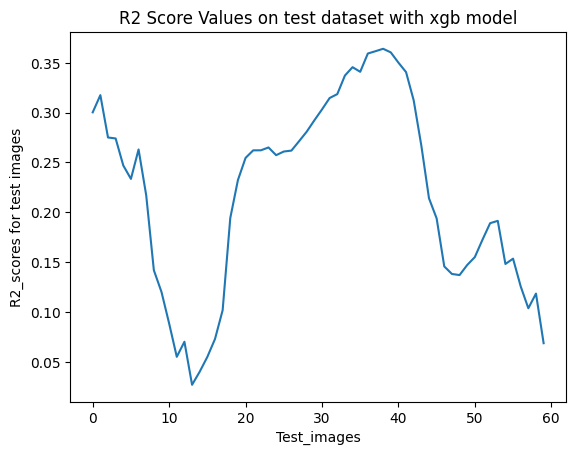

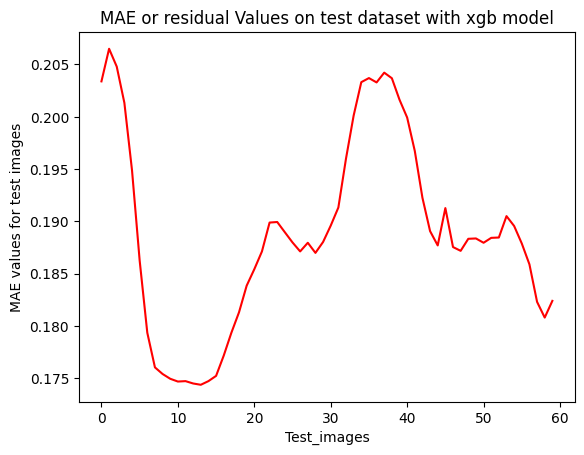

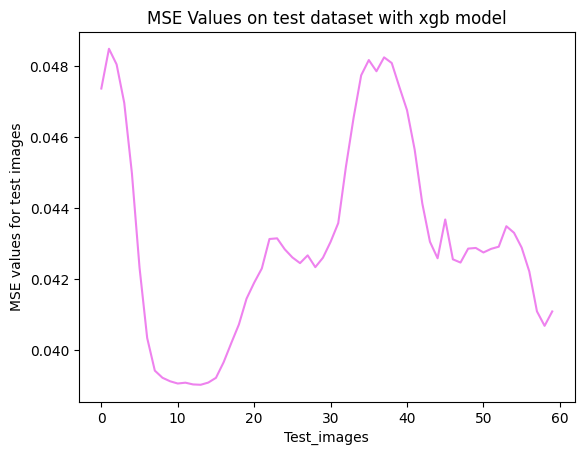

In [ ]:
R2_xgb = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_xgb_peninsular.npy")
error_xgb = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_xgb_peninsular.npy")
MSE_xgb = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_xgb_peninsular.npy")
plt.plot(R2_xgb)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with xgb model")
plt.show()
plt.plot(error_xgb,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with xgb model")
plt.show()
plt.plot(MSE_xgb, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with xgb model")
plt.show()

In [ ]:
np.mean(R2_xgb), np.max(R2_xgb), np.mean(error_xgb), np.mean(MSE_xgb)

(0.21777416960799917,
 0.36397973964537145,
 0.18868955675986146,
 0.04307843435569458)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=3,max_depth=2, verbose=2, n_jobs=-1)

# train model
forest.fit(train_image_flattened, train_label_flattened)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 3778.4min finished


RandomForestRegressor(max_depth=2, n_estimators=3, n_jobs=-1, verbose=2)

In [ ]:
predicted_RF = forest.predict(test_dataset.reshape(60,258048))
predicted_RF = predicted_RF.reshape(60,448,576)
print(predicted_RF.shape)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/Predicted_outputs_RF_peninsular.npy",predicted_RF)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished


(60, 448, 576)


0.0831263916791623 0.7558696076849264


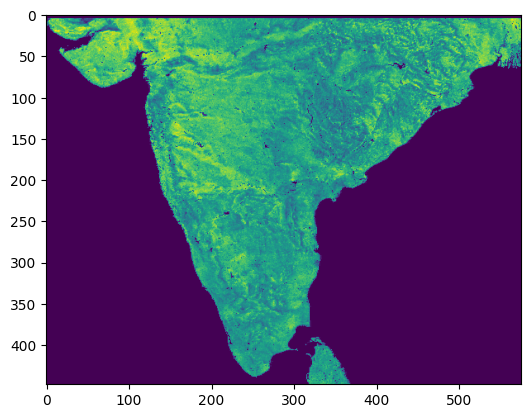

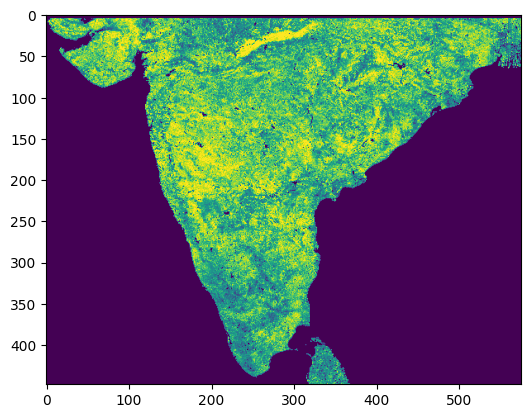

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
predicted_RF = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/Predicted_outputs_RF_peninsular.npy")
pred = predicted_RF[0].reshape(448,576)
yreal = test_labels[0].reshape(448,576)
r2 = r2_score(yreal,pred)
error = mae(yreal,pred)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)

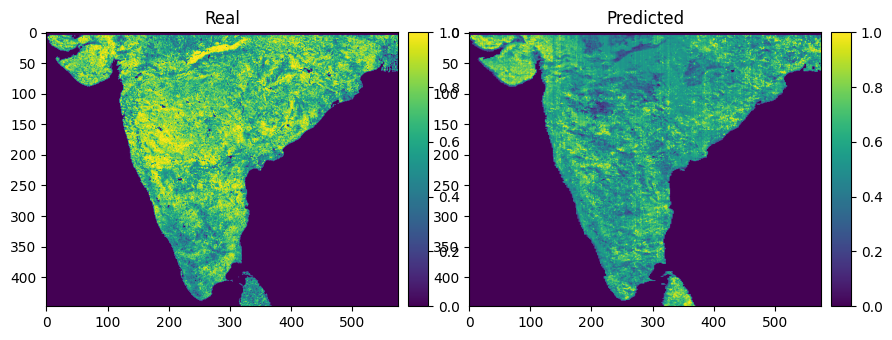

In [ ]:
images = [yreal, pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(448,576))
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

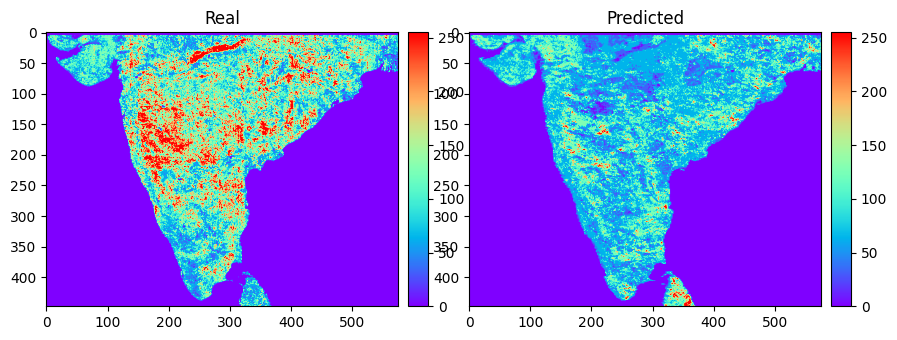

In [ ]:
unscale_pred = unscale(pred,y_test[0])
unscale_real = unscale(yreal,y_test[0])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(448,576), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
R2_RF =[]
error_RF =[]
yhat_RF =[]
MSE_RF = []
for i in range(len(test_dataset)):
    pred = predicted_RF[i].reshape(448,576)
    yreal = test_labels[i].reshape(448,576)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mse_err = mse(yreal,pred)
    yhat_RF.append(pred)
    R2_RF.append(r2)
    MSE_RF.append(mse_err)
    error_RF.append(err)
print(R2_RF)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_RF_peninsular.npy", R2_RF)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_RF_peninsular.npy", error_RF)
np.save(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_RF_peninsular.npy", MSE_RF)

[0.7558696076849264, 0.7292569356196634, 0.7228440912569427, 0.7238203122943019, 0.7358100171819095, 0.7651957927208404, 0.7932405854879099, 0.8049019129184908, 0.8085290709272929, 0.8056577569147529, 0.7991784959740289, 0.7919888084539168, 0.7825234949317108, 0.7801615777685194, 0.7876419048357448, 0.7955096613487973, 0.798525076863063, 0.8001987217258907, 0.8042548063390349, 0.801642358502375, 0.7949298145744552, 0.788056224978546, 0.7817642986621333, 0.7826888213180898, 0.7925156872209906, 0.7942086930131276, 0.7957641474361551, 0.796027244338541, 0.7967232614255677, 0.7945530524271063, 0.7882277992667325, 0.7813083914902186, 0.7641303483211082, 0.7432469701759497, 0.7216749871333468, 0.7413766978178464, 0.7356804796315447, 0.7328950375680251, 0.7406164209714095, 0.7488144494864982, 0.7572953818924625, 0.7707778925721228, 0.7869067785683157, 0.7954402940710648, 0.7957435573591813, 0.7888769617973141, 0.7899139717562151, 0.7832383796448066, 0.7747620032677671, 0.7749073428935905, 0.7

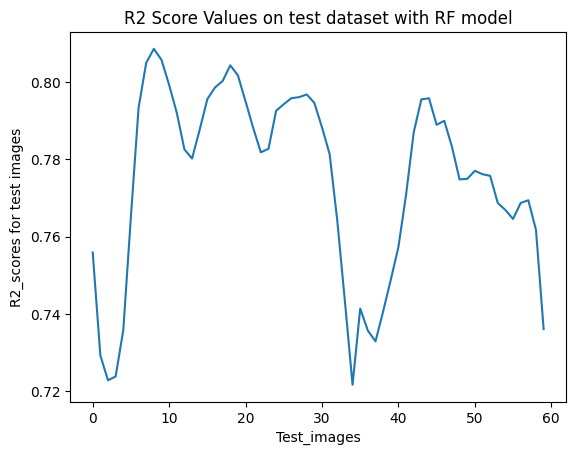

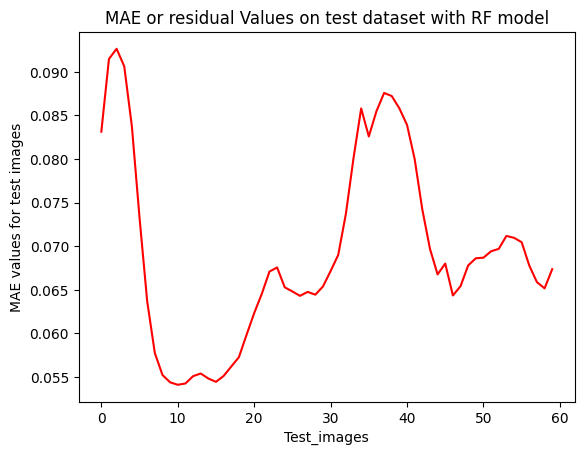

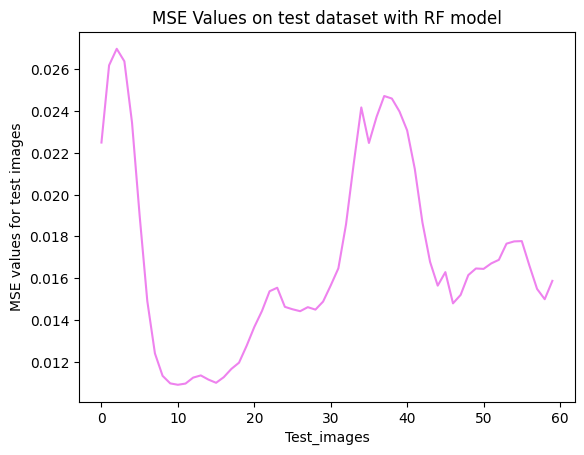

In [ ]:
R2_RF = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/R2_score_RF_peninsular.npy")
error_RF = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MAE_for_RF_peninsular.npy")
MSE_RF = np.load(r"E:\Jyoti Shukla - MS\rajasthan outputs\peninsular/MSE_for_RF_peninsular.npy")
plt.plot(R2_RF)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with RF model")
plt.show()
plt.plot(error_RF,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with RF model")
plt.show()
plt.plot(MSE_RF, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with RF model")
plt.show()

In [ ]:
np.mean(R2_RF), np.max(R2_RF), np.mean(error_RF), np.mean(MSE_RF)

(0.7747416903733522,
 0.8085290709272929,
 0.06921239426629242,
 0.01685427036587744)